# 영화 관객수 예측 미션

### 1. 출처 : [Dacon -영화 관객수 예측 미션](https://dacon.io/competitions/open/235536/overview/description/)


### 2. 목표 :  2010년대 한국에서 개봉한 한국영화 정보 데이터로 관객 수 예측


### 3. Column 설명

1. title : 영화의 제목
2. distributor : 배급사
3. genre : 장르
4. release_time : 개봉일
5. time : 상영시간(분)
6. screening_rat : 상영등급
7. director : 감독이름
8. dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
9. dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
10. num_staff : 스텝수
11. num_actor : 주연배우수
12. box_off_num : 관객수

---

## Library load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
sns.set(style = "whitegrid")

from IPython.display import set_matplotlib_formats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Mac OS를 이용하고 있기 떄문에 AppleGothic을 설정했습니다.
# 윈도우의 경우 다른 폰트를 사용해주셔야 합니다. 나눔폰트가 있는 경우 'NanumGothic' 없는 경우에는 'Malgun Gothic'을 사용해주세요.
matplotlib.rc('font', family='AppleGothic')
# matplotlib.rc('font', family='Malgun Gothic')

# 별도로, 폰트를 바꿀 경우 마이너스가 표시되지 않는 경우도 있는데 이를 막아주는 코드입니다.
matplotlib.rc('axes', unicode_minus=False)
matplotlib.rcParams['axes.unicode_minus'] = False

# retina 옵션을 통해 해상도를 올립니다.
set_matplotlib_formats('retina')

# 데이터 값을 소수점 두째자리까지 표시합니다.
# pd.options.display.float_format = '{:.2f}'.format

In [3]:
# 화면에 출력하는 데이터 프레임의 최대 row 수를 500으로 설정합니다.
pd.set_option('display.max_rows', 500)

# 화면에 출력하는 데이터 프레임의 최대 column 수를 500으로 설정합니다.
pd.set_option('display.max_columns', 500)

---

## Data load

In [4]:
# movies_train.csv 를 불러와 raw_train 이라는 변수에 할당합니다.
raw_train = pd.read_csv("data/movies_train.csv") 

print(raw_train.shape) # raw_train 의 row, column 갯수를 출력합니다.
raw_train.head() # raw_train 의 상위 5개 자료를 출력합니다.

(600, 12)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [5]:
# movies_test.csv 를 불러와 raw_test 라는 변수에 할당합니다.
raw_test = pd.read_csv("data/movies_test.csv") 

print(raw_test.shape) # raw_test 의 row, column 갯수를 출력합니다.
raw_test.head() # raw_test 의 상위 5개 자료를 출력합니다.

(243, 11)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


---

## Data preprocessing

### Type 확인

In [6]:
train = raw_train.copy() # raw_train 를 복사하여 train 이라는 변수에 할당합니다.

train.dtypes # train 내 컬럼의 type 을 확인합니다.

title              object
distributor        object
genre              object
release_time       object
time                int64
screening_rat      object
director           object
dir_prev_bfnum    float64
dir_prev_num        int64
num_staff           int64
num_actor           int64
box_off_num         int64
dtype: object

In [7]:
# release_time 컬럼을 datetime type 으로 변경 후 다시 release_time 컬럼에 할당합니다.
train["release_time"] = pd.to_datetime(train["release_time"])

train.dtypes # train 내 컬럼의 type 을 확인합니다.

title                     object
distributor               object
genre                     object
release_time      datetime64[ns]
time                       int64
screening_rat             object
director                  object
dir_prev_bfnum           float64
dir_prev_num               int64
num_staff                  int64
num_actor                  int64
box_off_num                int64
dtype: object

In [8]:
test = raw_test.copy() # raw_test 를 복사하여 test 라는 변수에 할당합니다.

test.dtypes # test 내 컬럼의 type 을 확인합니다.

title              object
distributor        object
genre              object
release_time       object
time                int64
screening_rat      object
director           object
dir_prev_bfnum    float64
dir_prev_num        int64
num_staff           int64
num_actor           int64
dtype: object

In [9]:
# release_time 컬럼을 datetime type 으로 변경 후 다시 release_time 컬럼에 할당합니다.
test["release_time"] = pd.to_datetime(test["release_time"])

test.dtypes # train 내 컬럼의 type 을 확인합니다.

title                     object
distributor               object
genre                     object
release_time      datetime64[ns]
time                       int64
screening_rat             object
director                  object
dir_prev_bfnum           float64
dir_prev_num               int64
num_staff                  int64
num_actor                  int64
dtype: object

### 결측치 확인

In [10]:
train.isnull().sum() # train 의 결측치를 확인합니다.

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

전체 row 갯수의 절반이 넘는 결측치가 dir_prev_bfnum 컬럼에 존재함을 확인 할 수 있습니다.

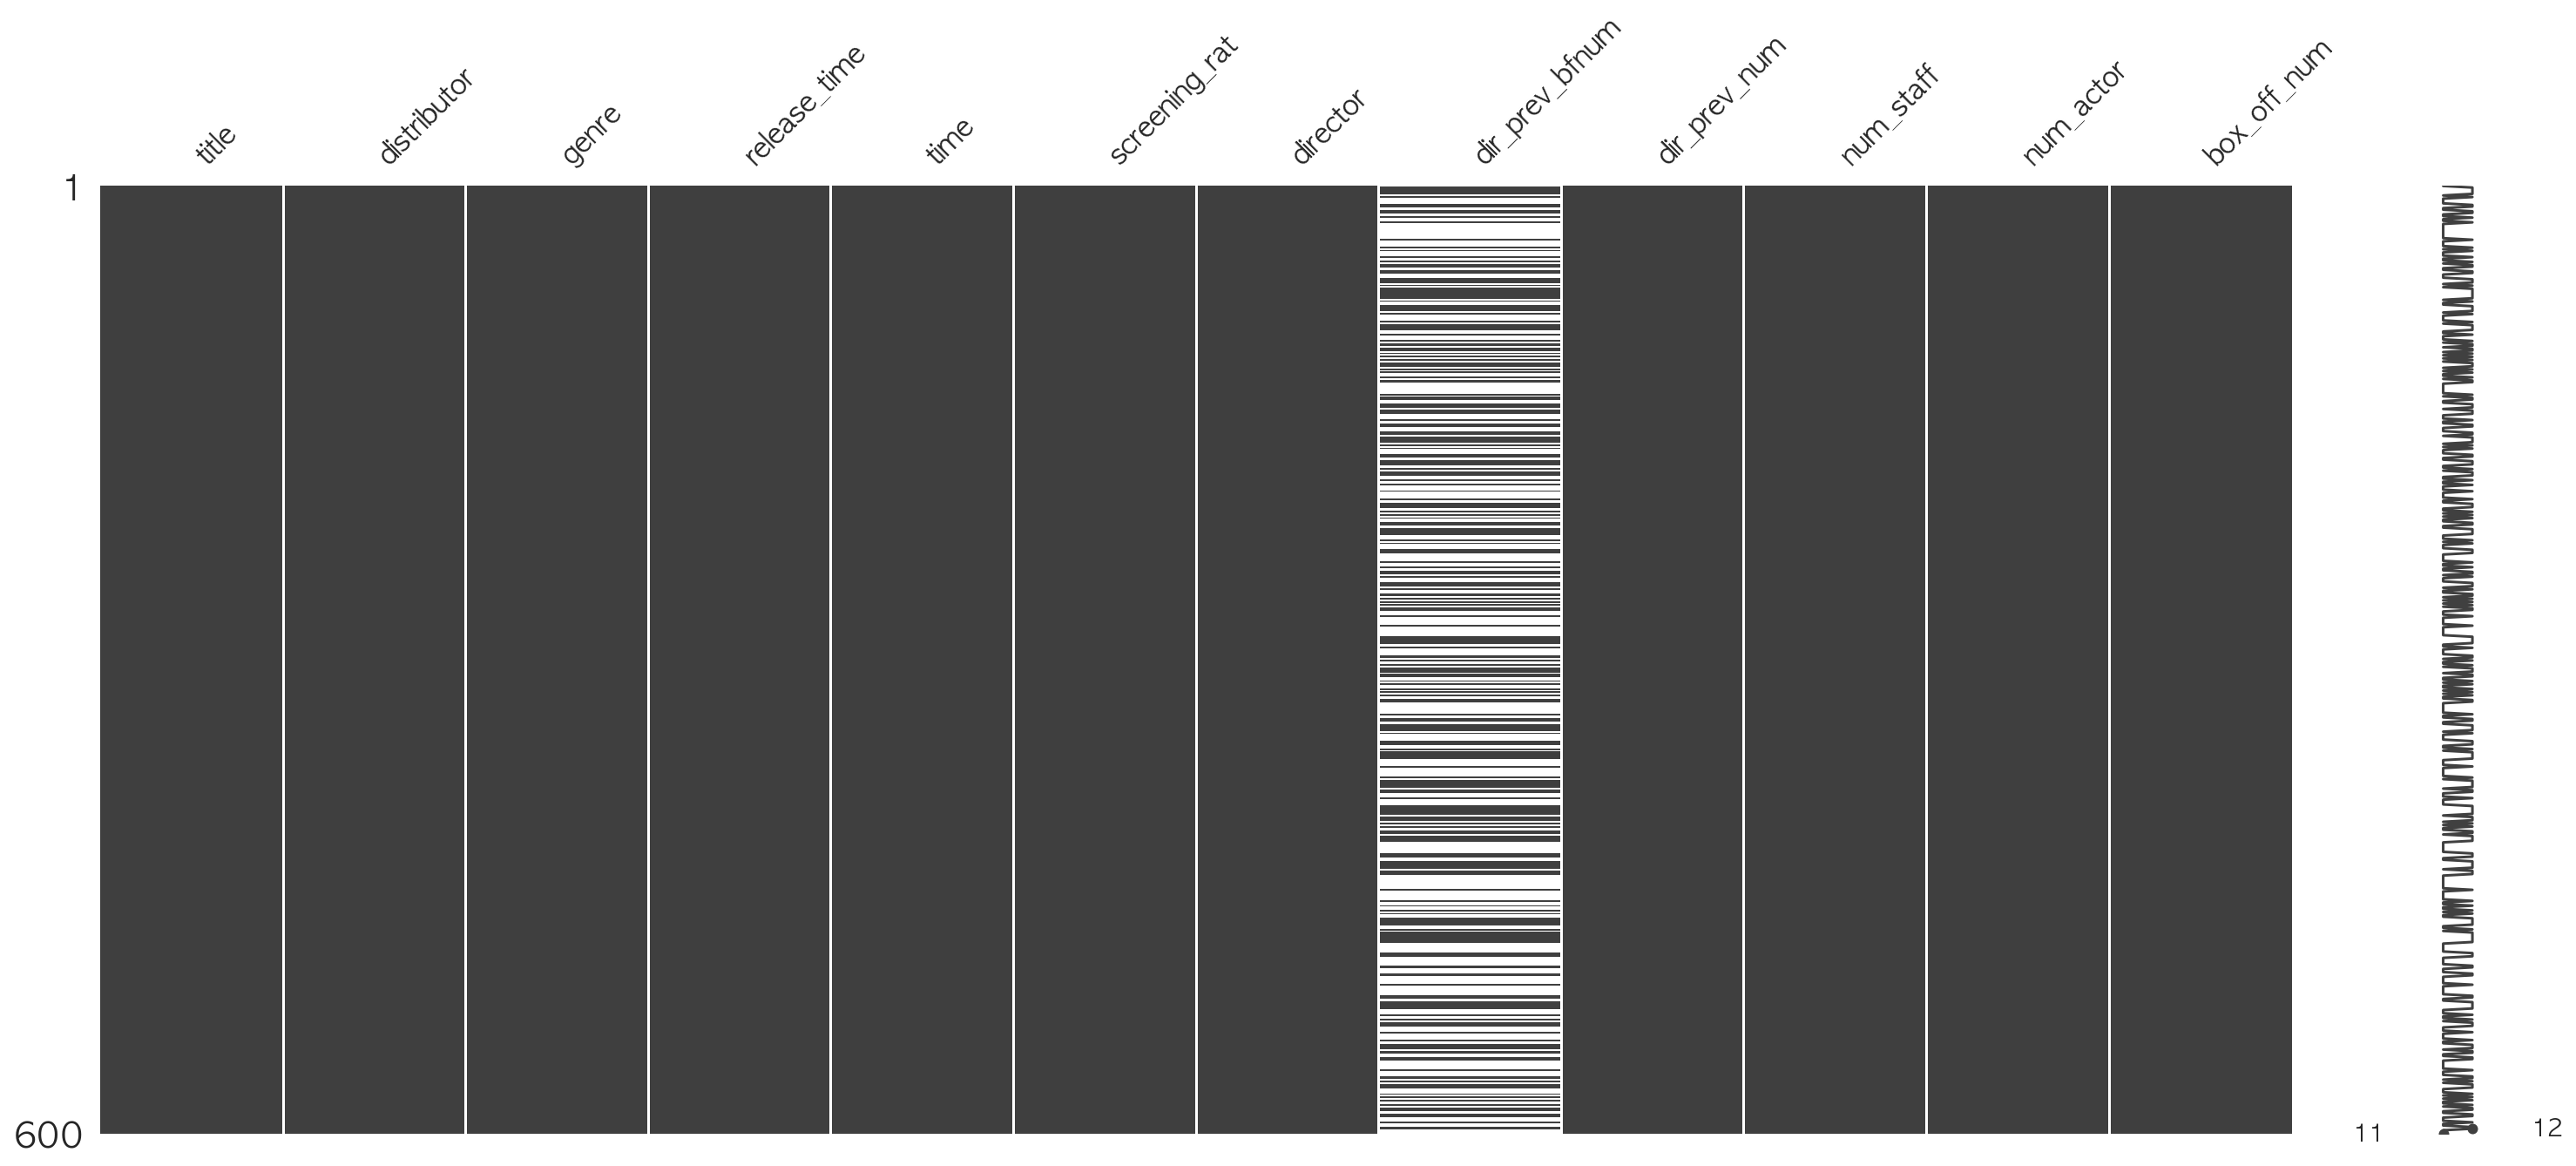

In [11]:
import missingno as msno

msno.matrix(train) # train 의 결측치를 시각화 합니다.

In [12]:
# dir_prev_bfnum 컬럼이 NaN 이고, dir_prev_num 컬럼이 0 인 데이터를 nan_data 라는 변수에 할당합니다.
nan_data = train[(train["dir_prev_bfnum"].isnull()) & (train["dir_prev_num"] == 0)]

print(nan_data.shape) # nan_data 의 row, column 갯수를 출력합니다.
nan_data.head() # nan_data 의 상위 5개 자료를 출력합니다.

(330, 12)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
6,길위에서,백두대간,다큐멘터리,2013-05-23,104,전체 관람가,이창재,NaN,0,32,5,53526
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,2014-09-18,129,전체 관람가,정성복,NaN,0,3,5,4778
9,청춘그루브,(주)두타연,드라마,2012-03-15,94,15세 관람가,변성현,NaN,0,138,3,868
10,AV 아이돌,(주) 케이알씨지,멜로/로맨스,2015-07-27,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745


dir_prev_bfnum 컬럼이 NaN 값이고 dir_prev_num 컬럼도 0 인 자료의 수가 dir_prev_bfnum 컬럼 NaN 값의 갯수와 동일한 것을 확인 할 수 있습니다.

즉, 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화가 없기 때문에 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수도 없다는 것을 추측 할 수 있습니다.

따라서 dir_prev_bfnum 컬럼이 NaN 값인 경우을 전부 0 으로 처리하도록 하겠습니다.

In [13]:
# dir_prev_bfnum 컬럼의 NaN 값을 전부 0 으로 처리 후 반올림 하여
# dir_prev_bfnum_clean 이라는 새로운 컬럼에 할당합니다.
train["dir_prev_bfnum_clean"] = train["dir_prev_bfnum"].fillna(0).round()

print(train.shape) # train 의 row, column 갯수를 출력합니다.

# dir_prev_bfnum 컬럼, dir_prev_bfnum_clean 컬럼의 상위 5개 자료를 출력합니다.
train[["dir_prev_bfnum", "dir_prev_bfnum_clean"]].head()

(600, 13)


,dir_prev_bfnum,dir_prev_bfnum_clean
0,NaN,0.0
1,1161602.50,1161602.0
2,220775.25,220775.0
3,23894.00,23894.0
4,1.00,1.0


test 도 train 과 동일하게 처리합니다.

In [14]:
test.isnull().sum() # test 의 결측치를 확인합니다.

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

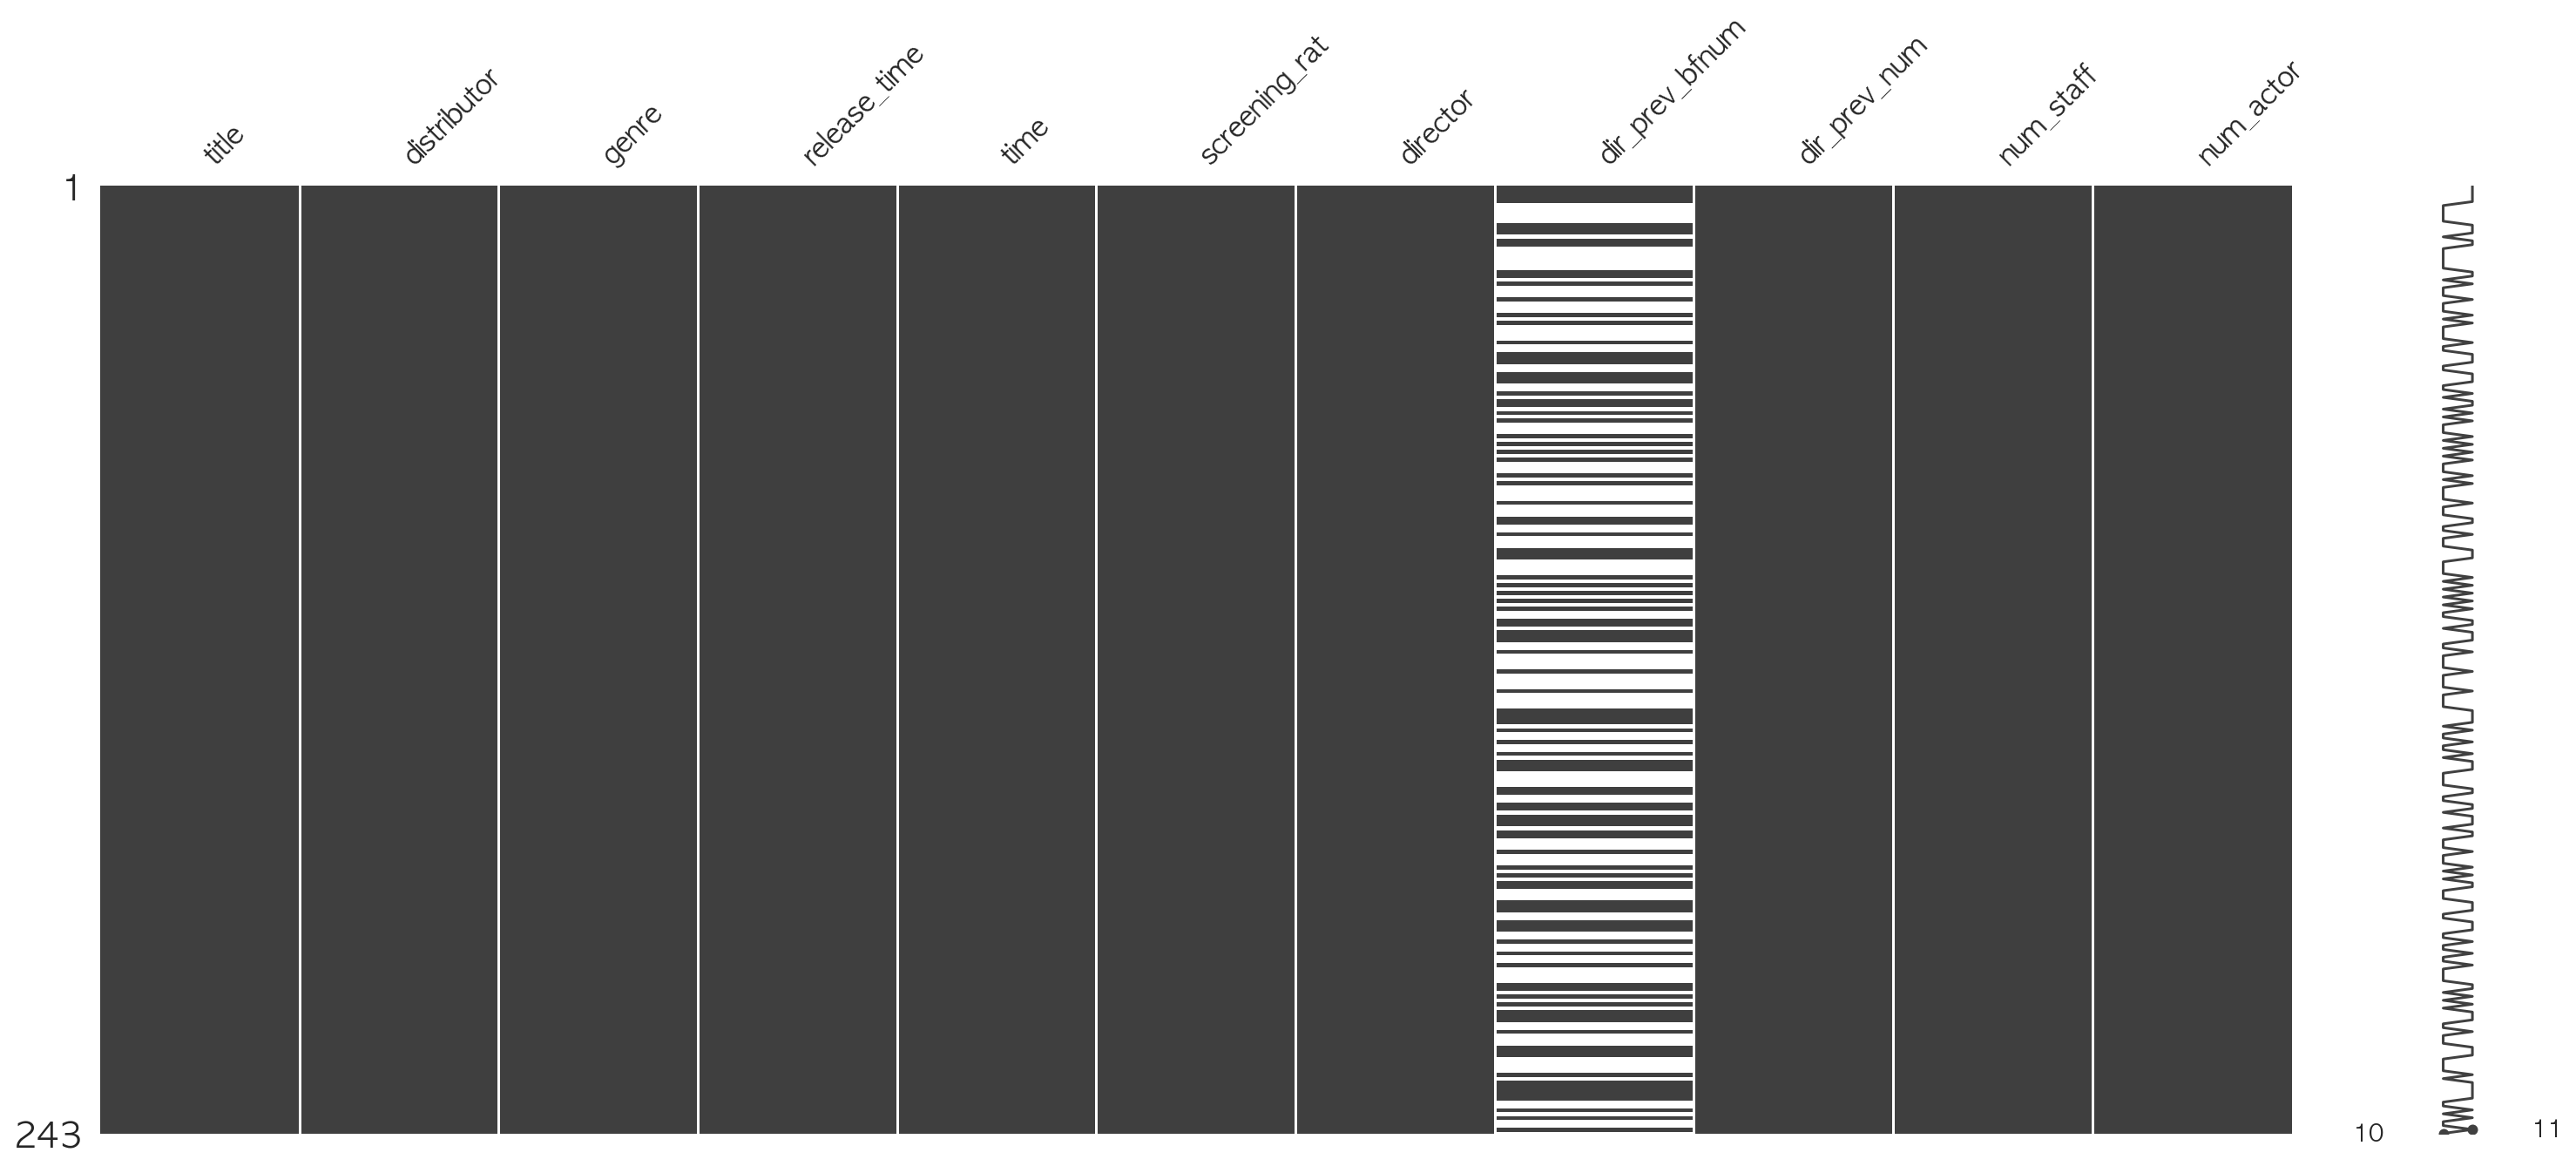

In [15]:
msno.matrix(test) # test 의 결측치를 시각화합니다.

In [16]:
# dir_prev_bfnum 컬럼이 NaN 이고, dir_prev_num 컬럼이 0 인 데이터를 nan_data 라는 변수에 할당합니다.
nan_data = test[(test["dir_prev_bfnum"].isnull()) & (test["dir_prev_num"] == 0)]

print(nan_data.shape) # nan_data 의 row, column 갯수를 출력합니다.
nan_data.head() # nan_data 의 상위 5개 자료를 출력합니다.

(136, 11)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
5,회오리 바람,모쿠슈라,드라마,2010-02-25,95,15세 관람가,장건재,NaN,0,156,2
6,경계도시 2,시네마 달,다큐멘터리,2010-03-18,104,15세 관람가,홍형숙,NaN,0,11,2
7,이웃집 남자,(주)루믹스미디어,드라마,2010-03-18,100,청소년 관람불가,장동홍,NaN,0,117,5
8,아마존의 눈물 극장판,마운틴픽쳐스,다큐멘터리,2010-03-25,88,15세 관람가,김진만,NaN,0,76,1
9,반가운 살인자,롯데쇼핑(주)롯데엔터테인먼트,코미디,2010-04-08,107,15세 관람가,김동욱,NaN,0,255,3


test 역시 dir_prev_bfnum 컬럼이 NaN 값이고 dir_prev_num 컬럼도 0 인 자료의 수가 dir_prev_bfnum 컬럼 NaN 값의 갯수와 동일한 것을 확인 할 수 있습니다.

In [17]:
# dir_prev_bfnum 컬럼의 NaN 값을 전부 0 으로 처리 후 반올림하여
# dir_prev_bfnum_clean 이라는 새로운 컬럼에 할당합니다.
test["dir_prev_bfnum_clean"] = test["dir_prev_bfnum"].fillna(0).round()

print(test.shape) # test 의 row, column 갯수를 출력합니다.

# dir_prev_bfnum_clean 컬럼 값이 0 인 데이터 중 dir_prev_bfnum 컬럼, dir_prev_bfnum_clean 컬럼의
# 상위 5개 자료를 출력합니다.
test.loc[test["dir_prev_bfnum_clean"] == 0, ["dir_prev_bfnum", "dir_prev_bfnum_clean"]].head()

(243, 12)


,dir_prev_bfnum,dir_prev_bfnum_clean
5,NaN,0.0
6,NaN,0.0
7,NaN,0.0
8,NaN,0.0
9,NaN,0.0


### release_time 컬럼 처리

In [18]:
# release_time 컬럼을 연/월/일 순으로 구분하여 각각의 컬럼에 할당합니다.
train["release_time_year"] = pd.to_datetime(train["release_time"]).dt.year
train["release_time_month"] = pd.to_datetime(train["release_time"]).dt.month
train["release_time_day"] = pd.to_datetime(train["release_time"]).dt.day
train["release_time_weekday"] = pd.to_datetime(train["release_time"]).dt.weekday_name

print(train.shape) # train 의 row, column 갯수를 출력합니다.

# release_time, release_time_year, release_time_month, release_time_day, release_time_weekday 컬럼의
# 상위 5개 자료를 출력합니다.
train[["release_time", "release_time_year", "release_time_month", "release_time_day", "release_time_weekday"]].head()

(600, 17)


,release_time,release_time_year,release_time_month,release_time_day,release_time_weekday
0,2012-11-22,2012,11,22,Thursday
1,2015-11-19,2015,11,19,Thursday
2,2013-06-05,2013,6,5,Wednesday
3,2012-07-12,2012,7,12,Thursday
4,2010-11-04,2010,11,4,Thursday


In [19]:
# test 도 train 과 동일하게 처리합니다.
test["release_time_year"] = pd.to_datetime(test["release_time"]).dt.year
test["release_time_month"] = pd.to_datetime(test["release_time"]).dt.month
test["release_time_day"] = pd.to_datetime(test["release_time"]).dt.day
test["release_time_weekday"] = pd.to_datetime(test["release_time"]).dt.weekday_name

print(test.shape) # test 의 row, column 갯수를 출력합니다.

# release_time, release_time_year, release_time_month, release_time_day, release_time_weekday 컬럼의
# 상위 5개 자료를 출력합니다.
test[["release_time", "release_time_year", "release_time_month", "release_time_day", "release_time_weekday"]].head()

(243, 16)


,release_time,release_time_year,release_time_month,release_time_day,release_time_weekday
0,2010-01-07,2010,1,7,Thursday
1,2010-01-14,2010,1,14,Thursday
2,2010-01-28,2010,1,28,Thursday
3,2010-02-04,2010,2,4,Thursday
4,2010-02-18,2010,2,18,Thursday


---

## E.D.A

### distributor 컬럼

In [20]:
# pivot_table 을 사용하여 train 의 테이블을 만든 후 table_distributor 컬럼에 할당합니다.
table_distributor = pd.pivot_table(train,
                                   index = "distributor", # index 는 distributor 로 설정합니다.
                                   values = "box_off_num", # values 는 box_off_num 로 설정합니다.
                                   aggfunc = ["sum", "count"]) # 누적 합계와 누적 갯수를 출력합니다.

# table_distributor 의 컬럼명을 sum, count 로 설정합니다.
table_distributor.columns = ["sum", "count"]

# table_distributor 를 sum 을 기준으로 높은 값 순으로 정렬 후
# table_distributor_sum 에 할당합니다.
table_distributor_sum = table_distributor.sort_values(by = "sum", ascending = False)

table_distributor_sum # table_distributor_sum 를 출력합니다.

,sum,count
distributor,,
CJ 엔터테인먼트,116788093,54
(주)쇼박스,88053064,26
(주)NEW,65532145,30
롯데엔터테인먼트,64383745,52
CJ E&M Pictures,8244674,2
NEW,8152133,8
CJ E&M 영화부문,7515928,3
CGV아트하우스,6590943,5
시네마서비스,5381059,6


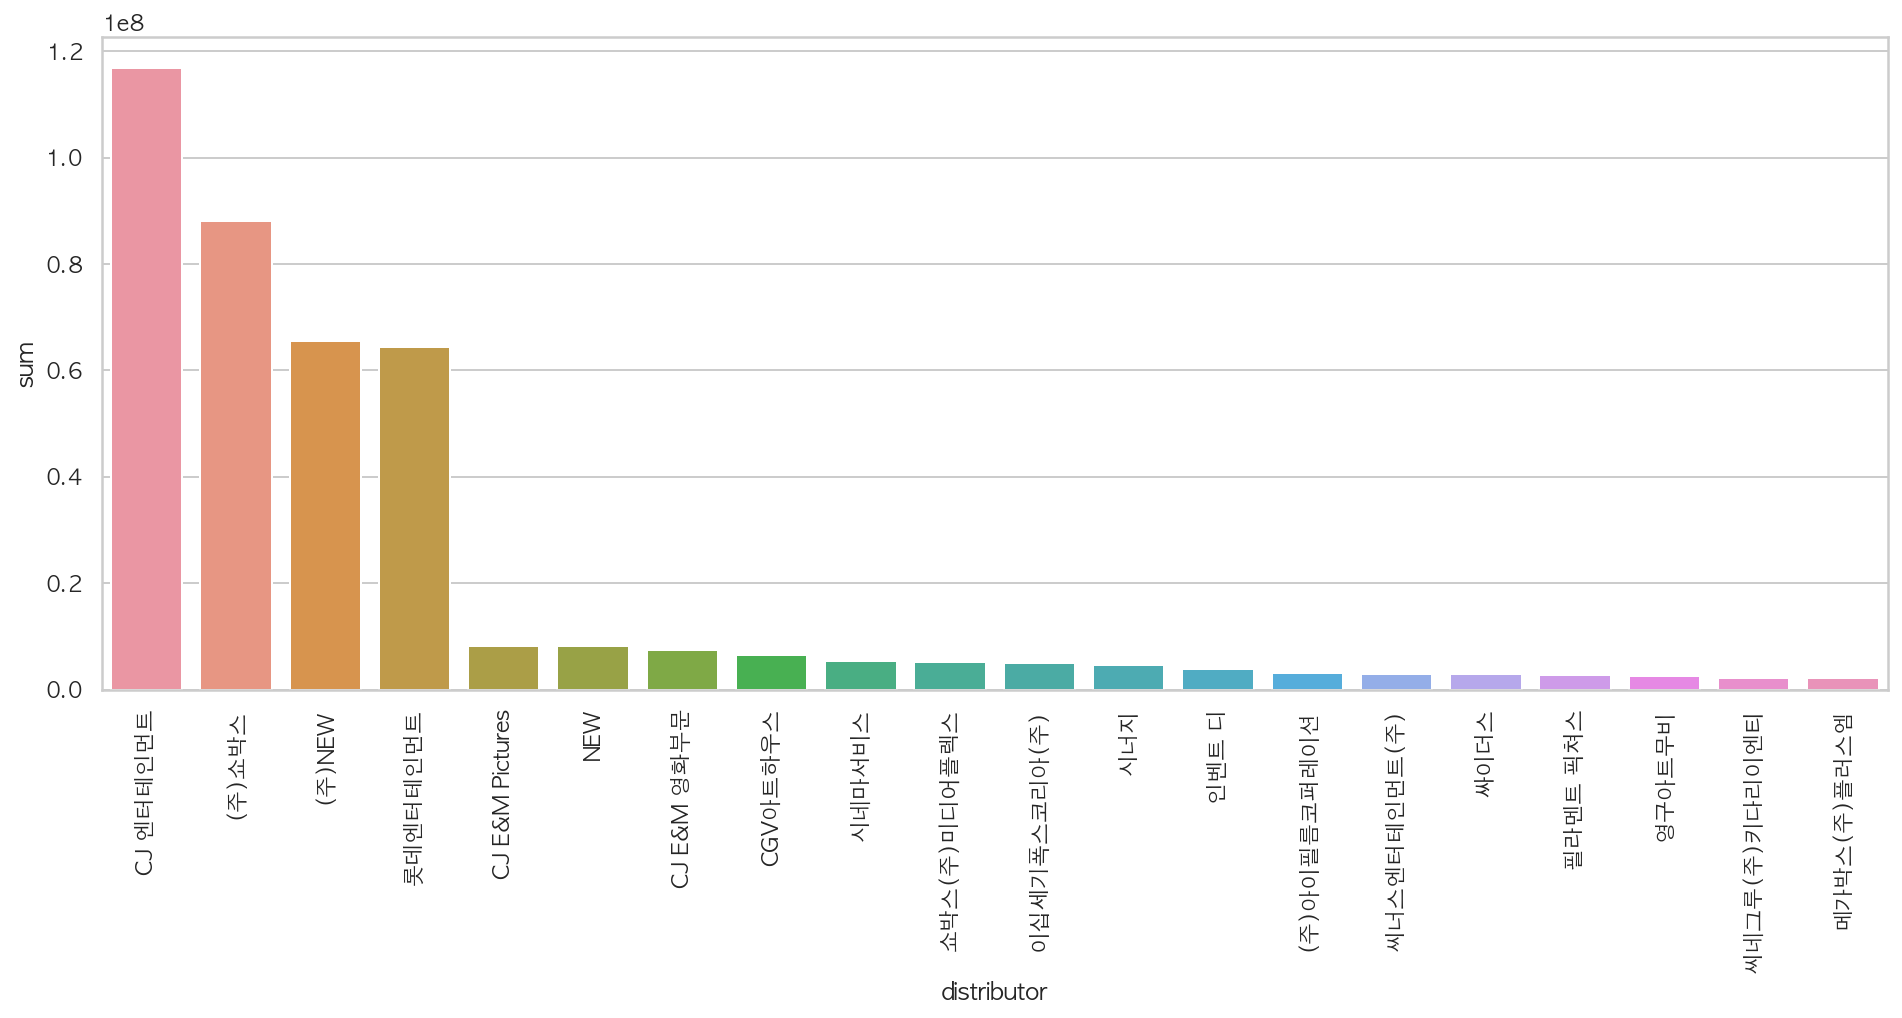

In [21]:
# table_distributor_sum 의 상위 20개 데이터를 table_distributor_top20 에 할당합니다.
table_distributor_top20 = table_distributor_sum.head(20)

plt.figure(figsize = (16, 6)) # 차트 크기를 가로 16인치, 세로 6인치로 설정합니다.

# barplot 으로 시각화 후 ax 에 할당 합니다.
ax = sns.barplot(data = table_distributor_top20,
                 x = table_distributor_top20.index, # x 축은 index 로 설정합니다.
                 y = "sum") # y 축은 sum 으로 설정합니다.

# x 축 label 을 90도 회전합니다.
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

ax # ax 를 출력합니다.

상위 20개 배급사(distributor) 중에서도 메이저 업체(CJ엔터테인먼트, (주)쇼박스, (주)NEW, 롯데엔터테인먼트) 4 곳의 관객 수 비중이 상당히 높은 것으로 확인 할 수 있습니다.

In [22]:
# table_distributor 를 count 를 기준으로 높은 값 순으로 정렬 후
# table_distributor_count 컬럼에 할당합니다.
table_distributor_count = table_distributor.sort_values(by = "count", ascending = False)

table_distributor_count # table_distributor_count 를 출력합니다.

,sum,count
distributor,,
CJ 엔터테인먼트,116788093,54
롯데엔터테인먼트,64383745,52
(주)NEW,65532145,30
(주)마운틴픽쳐스,937924,29
(주)쇼박스,88053064,26
인디스토리,135475,26
골든타이드픽처스,65598,15
(주) 케이알씨지,14382,14
(주)키노아이,35293,10


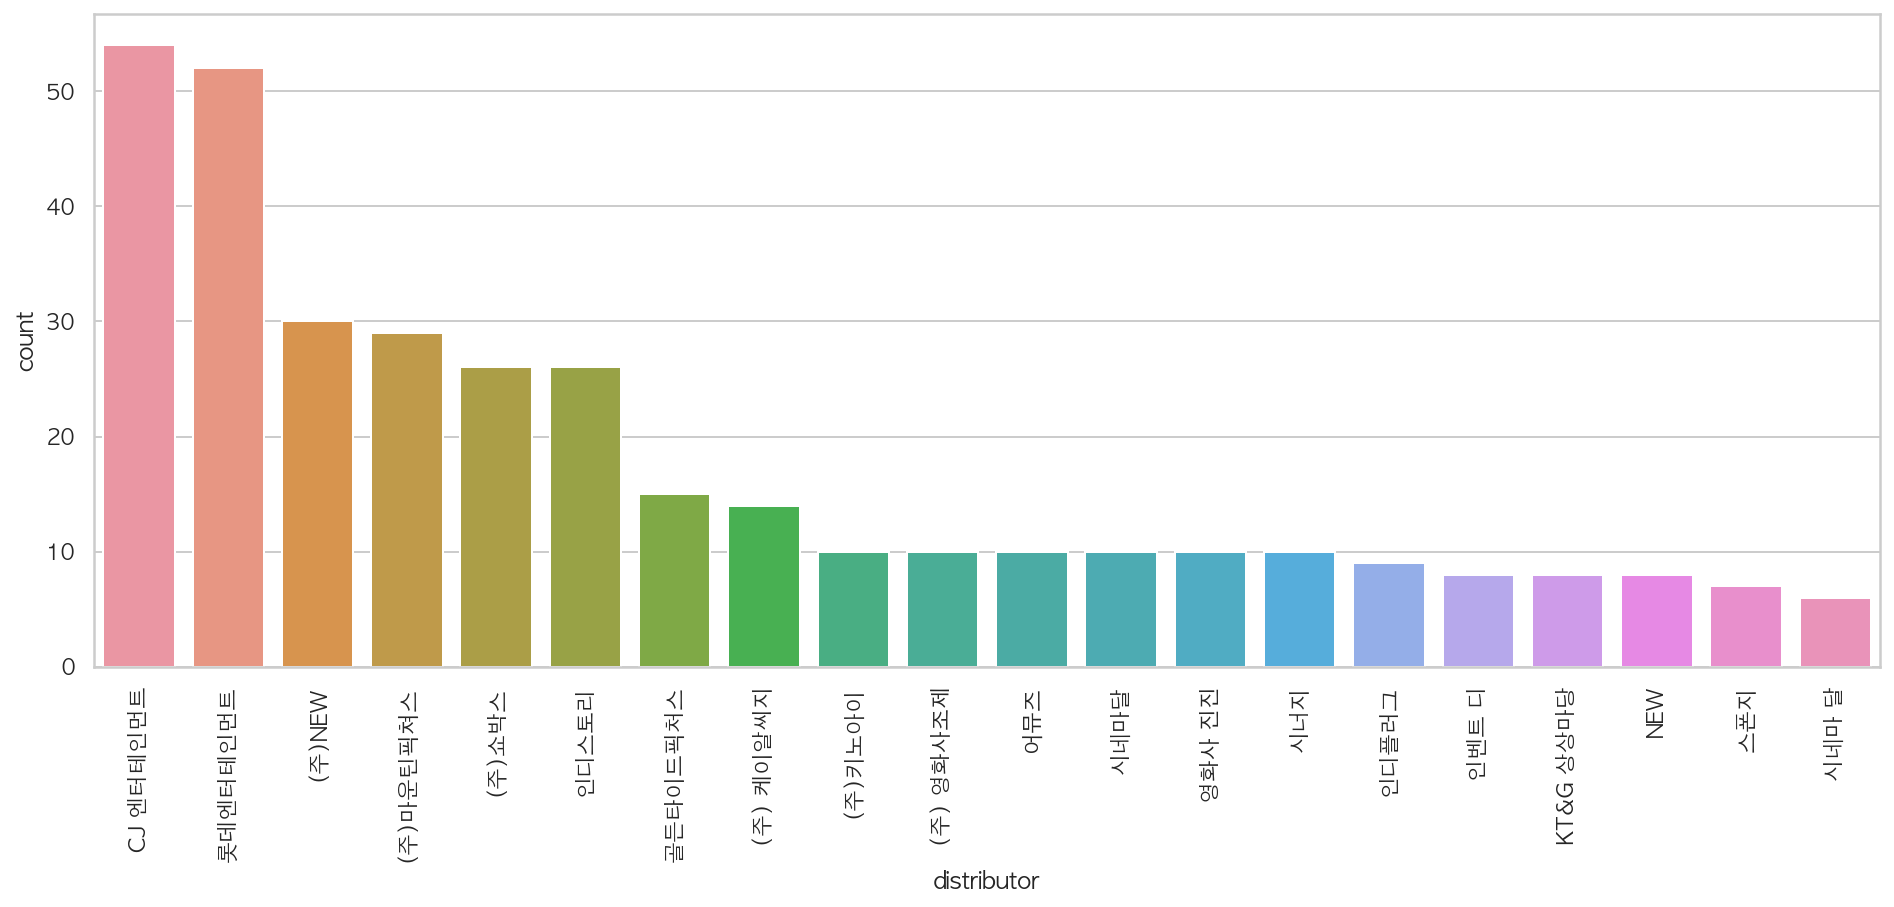

In [23]:
# table_distributor_count의 상위 20개 데이터를 table_distributor_top20 에 할당합니다.
table_distributor_top20 = table_distributor_count.head(20)

plt.figure(figsize = (16, 6)) # 차트 크기를 가로 16인치, 세로 6인치로 설정합니다.

# barplot 으로 시각화 후 ax 에 할당 합니다.
ax = sns.barplot(data = table_distributor_top20,
                 x = table_distributor_top20.index, # x 축은 index 로 설정합니다.
                 y = "count") # y 축은 sum 으로 설정합니다.

# x 축 label 을 90도 회전합니다.
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

ax # ax 를 출력합니다.

배급 영화 수 에서도 메이저 업체(CJ엔터테인먼트, (주)쇼박스, (주)NEW, 롯데엔터테인먼트) 4 곳의 비중이 높은 것으로 확인 할 수 있습니다.

즉, 4곳의 메이저 업체에서 영화 배급을 하면 관객 수는 어느 정도 보장 될 것이라는 추측을 할 수 있습니다.

### genre 컬럼

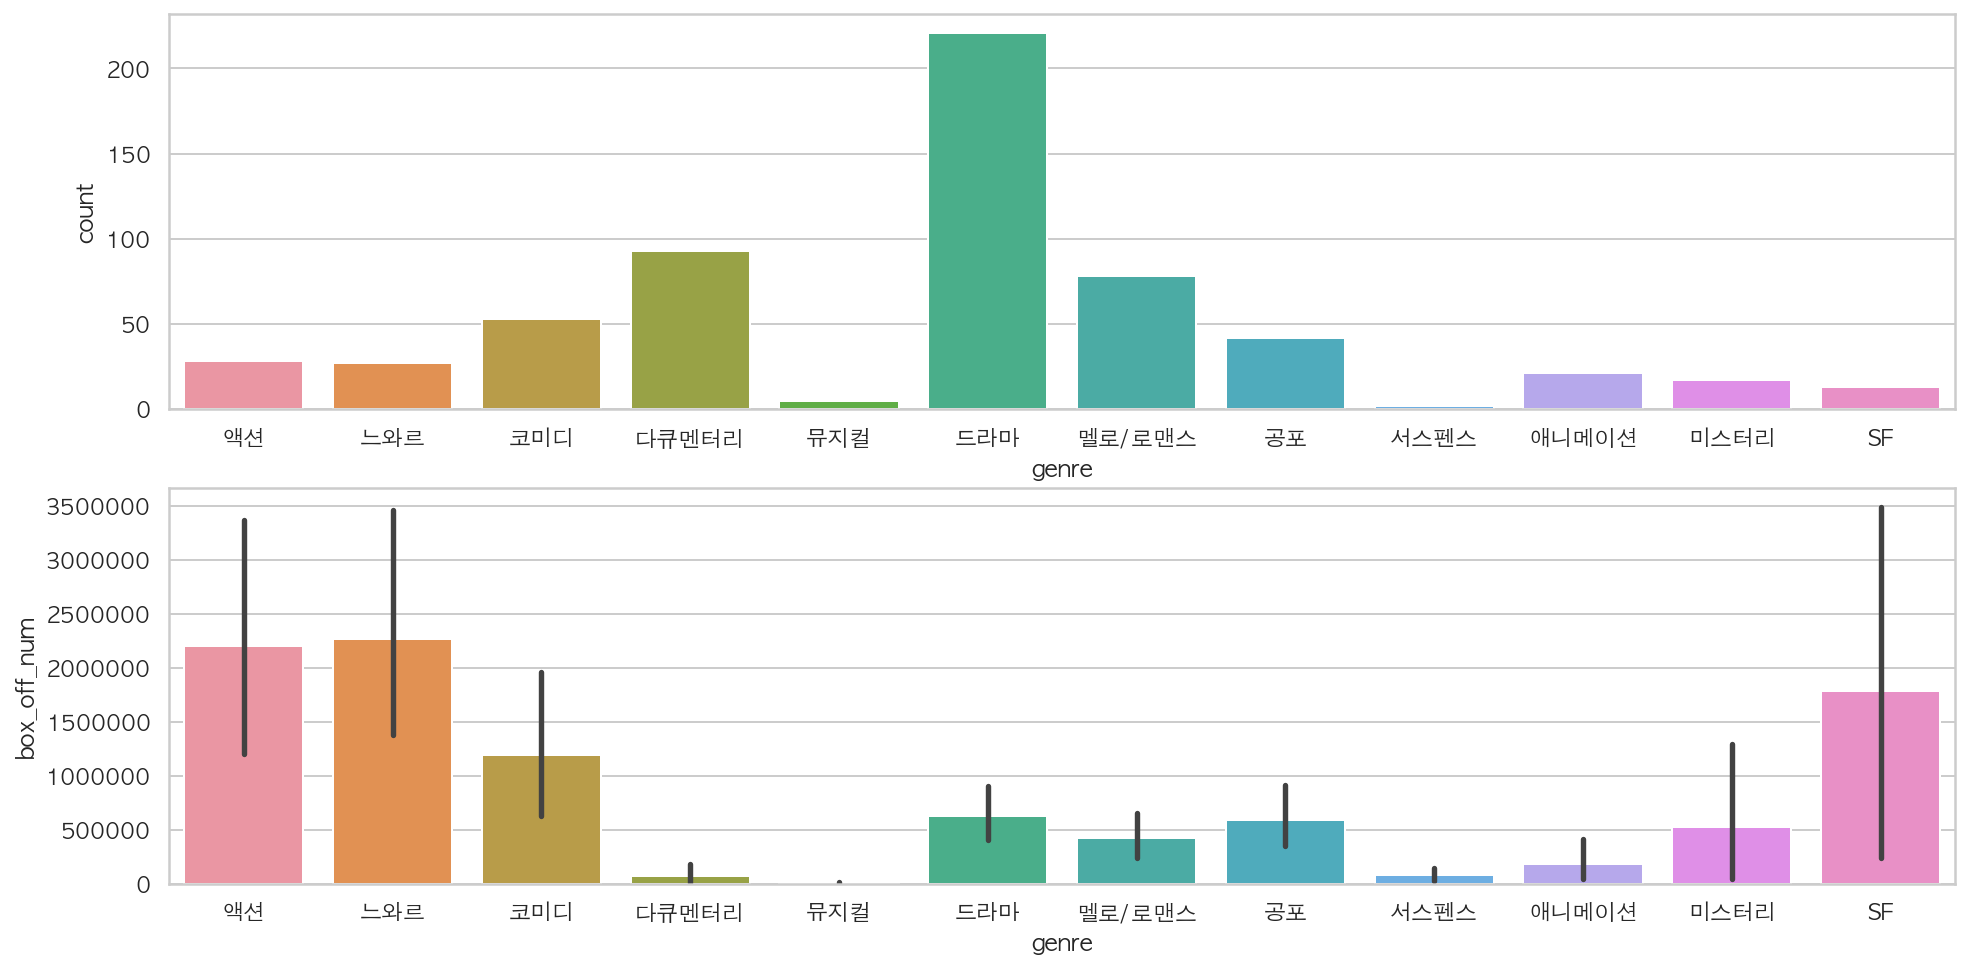

In [24]:
# 차트를 여러개 그리기 위한 설정을 합니다.
figure, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1)

figure.set_size_inches(16,8) # 차트 크기를 가로 16인치, 세로 8인치로 설정합니다.

# countplot 으로 genre 컬럼의 종류별 갯수를 시각화 합니다.
sns.countplot(data = train, x = "genre", ax = ax1)

# barplot 으로 genre 컬럼의 종류별 관객수를 시각화 합니다.
sns.barplot(data = train, x = "genre", y = "box_off_num", ax = ax2)

드라마 장르가 압도적으로 많이 개봉하지만 관객 수가 많지 않고, 실제 관객수는 느와르 > 액션 > SF 순으로 많은 것을 확인 할 수 있습니다.

액션, 느와르, SF 의 경우, 표준편차가 상당히 큰 것으로 볼 때 적은 개봉 수에도 관객을 끌어 모으는 대작들이 많다는 추측을 할 수 있습니다.

### release_time 컬럼

- 전처리된 release_time_year, release_time_month, release_time_day, release_time_weekday 컬럼 사용

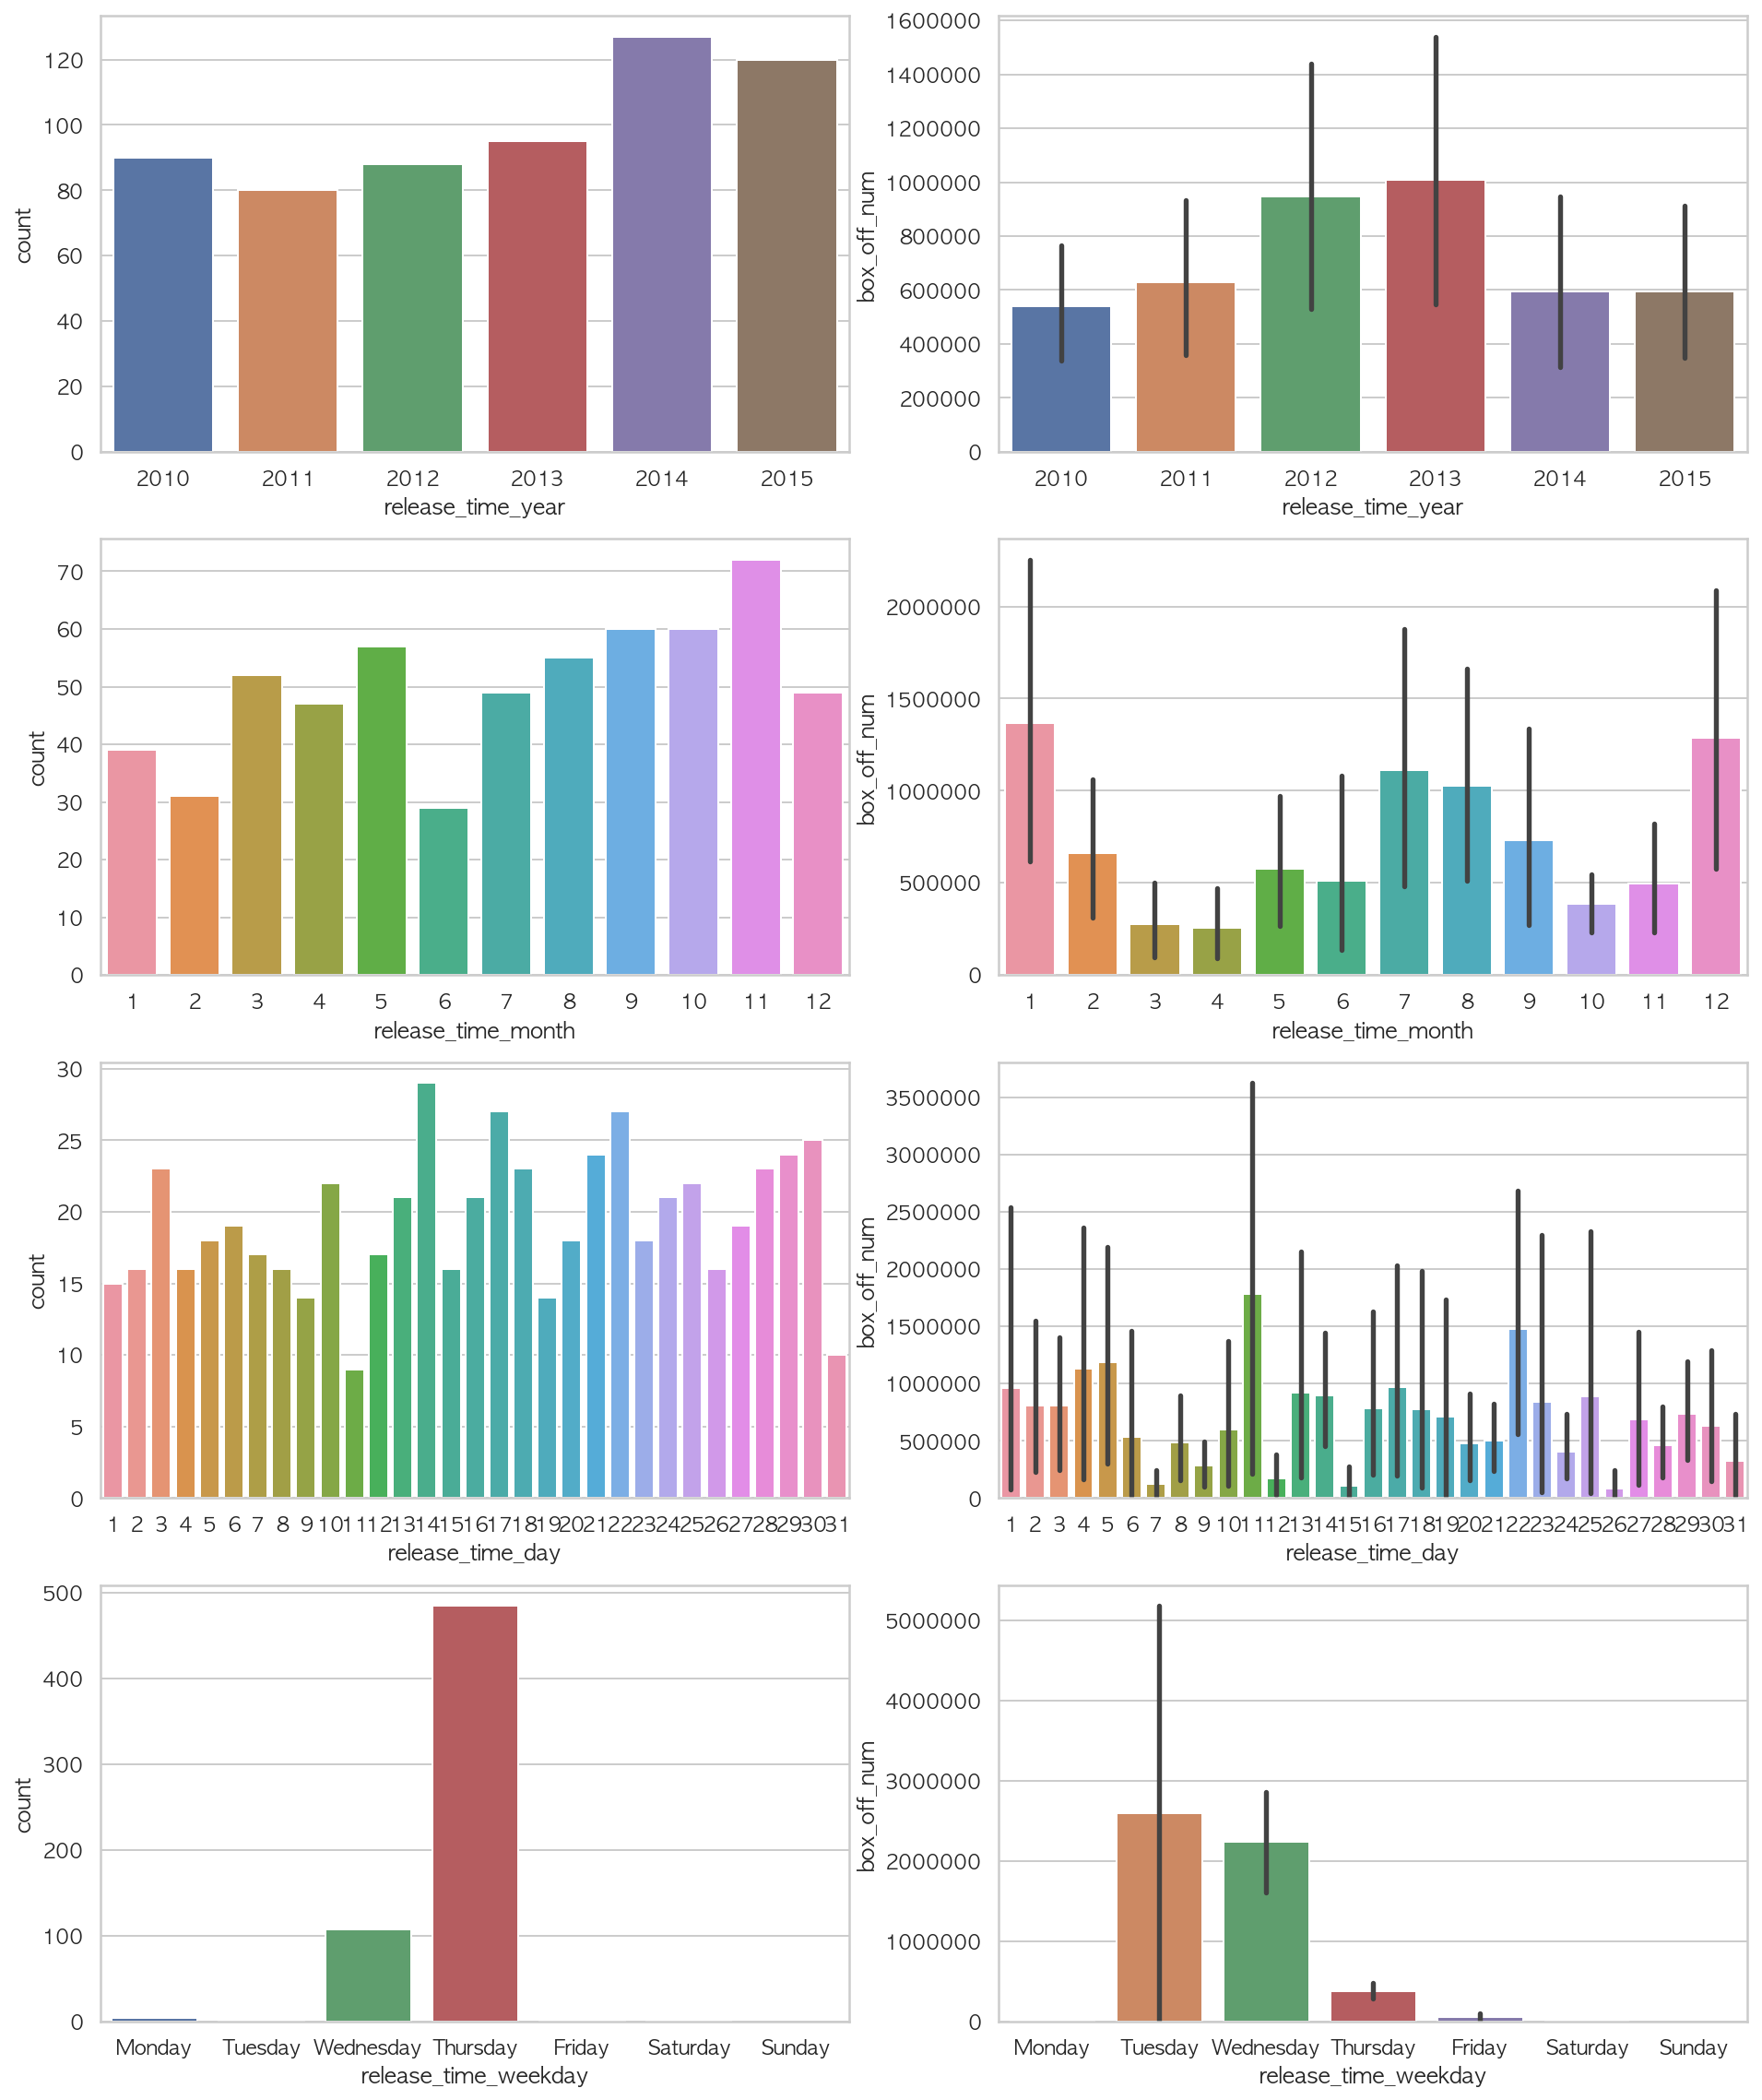

In [25]:
# 차트를 여러개 그리기 위한 설정을 합니다.
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows = 4, ncols = 2)

figure.set_size_inches(16,20) # 차트 크기를 가로 16인치, 세로 8인치로 설정합니다.

# countplot 을 사용해 release_time_year 컬럼의 갯수를 시각화 합니다.
sns.countplot(data = train, x = "release_time_year", ax = ax1)

# barplot 을 이용해 release_time_year 컬럼의 종류별 관객수를 시각화 합니다.
sns.barplot(data = train, x = "release_time_year", y = "box_off_num", ax = ax2)

# countplot 을 사용해 release_time_month 컬럼의 갯수를 시각화 합니다.
sns.countplot(data = train, x = "release_time_month", ax = ax3)

# barplot 을 이용해 release_time_month 컬럼의 종류별 관객수를 시각화 합니다.
sns.barplot(data = train, x = "release_time_month", y = "box_off_num", ax = ax4)

# countplot 을 사용해 release_time_day 컬럼의 갯수를 시각화 합니다.
sns.countplot(data = train, x = "release_time_day", ax = ax5)

# barplot 을 이용해 release_time_day 컬럼의 종류별 관객수를 시각화 합니다.
sns.barplot(data = train, x = "release_time_day", y = "box_off_num", ax = ax6)

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# countplot 을 사용해 release_time_weekday 컬럼의 갯수를 시각화 합니다.
sns.countplot(data = train, x = "release_time_weekday", order = order, ax = ax7)

# barplot 을 이용해 release_time_weekday 컬럼의 종류별 관객수를 시각화 합니다.
sns.barplot(data = train, x = "release_time_weekday", y = "box_off_num", order = order, ax = ax8)

요일의 경우, 대부분의 영화가 목요일에 개봉하며 나머지 중 대부분이 수요일에 개봉한다는 것을 알 수 있습니다.

하지만 관객 수의 경우, 수요일에 개봉한 영화가 목요일에 개봉한 영화보다 압도적으로 많습니다. 즉, 수요일에 사람들이 많이 보고 싶어하는 영화들이 개봉 한다는 것을 추측할 수 있습니다.

연 / 월 / 일의 경우, 일부 차이가 있으나 관객 수에 영향이 있을 만한 정도는 아니라고 추측을 할 수 있습니다.

### time 컬럼

In [26]:
# pivot_table 을 사용하여 train 의 테이블을 만든 후 table_time 컬럼에 할당합니다.
table_time = pd.pivot_table(train,
                            index = "time", # index 는 time 로 설정합니다.
                            values = "box_off_num", # values 는 box_off_num 로 설정합니다.
                            aggfunc = "sum") # 누적 합계를 출력합니다.

# table_time 컬럼명을 sum 으로 변경합니다.
table_time.columns = ["sum"]

# table_time 를 sum 을 기준으로 높은 값 순으로 정렬 후 다시 table_time 에 할당합니다.
table_time = table_time.sort_values(by = "sum", ascending = False)

table_time # table_distributor_sum 를 출력합니다.

,sum
time,
127,33952225
124,33011320
139,23824100
135,21989465
120,19729666
121,18115411
119,16774709
111,16085267
130,15738709


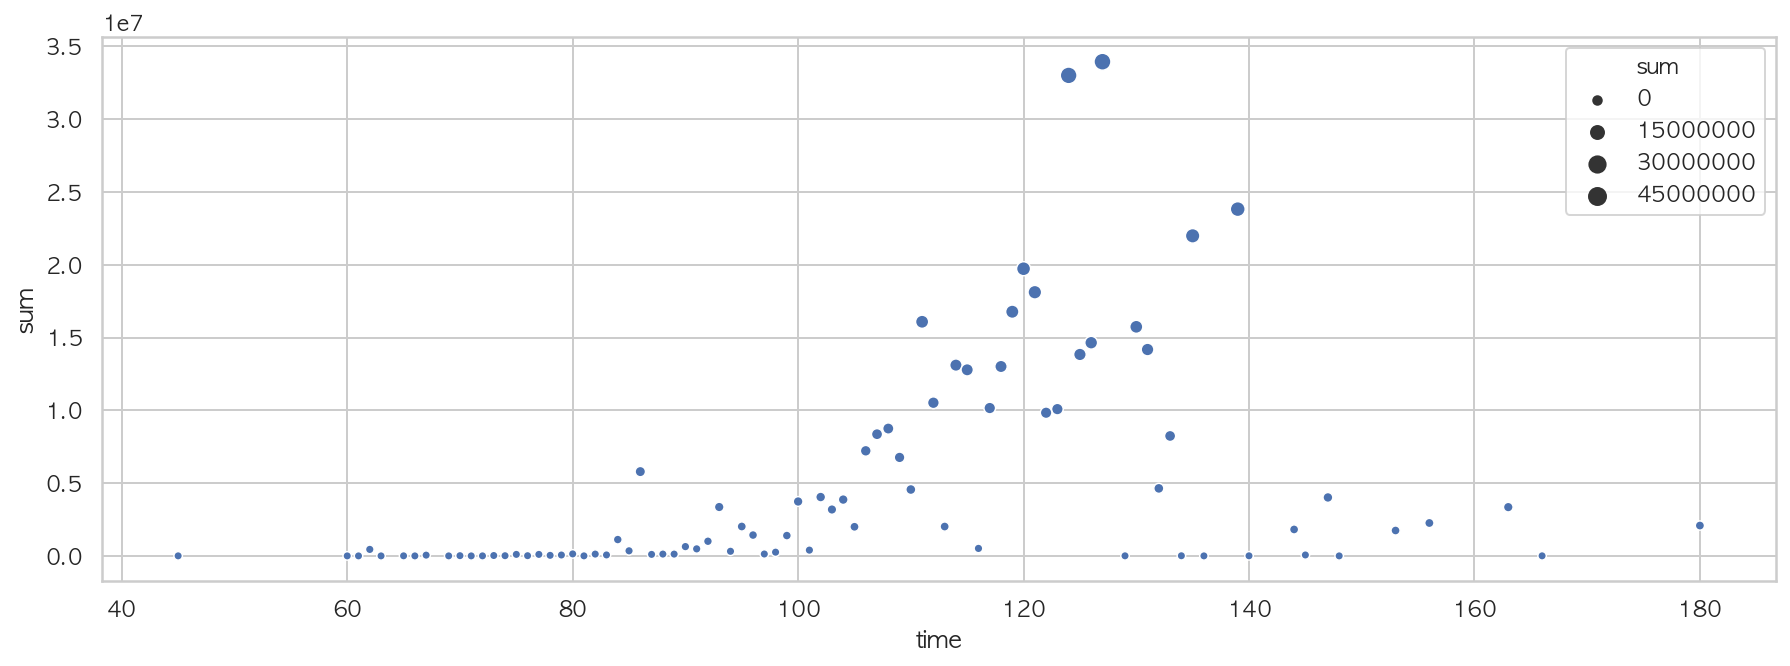

In [27]:
plt.figure(figsize = (15, 5)) # 차트 크기를 가로 15인치, 세로 5인치로 설정합니다.

# scatterplot 으로 table_time 을 시각화 합니다.
sns.scatterplot(data = table_time,
                x = table_time.index, # x 축은 table_time.index 를 설정합니다.
                y = "sum", # y 축은 sum 컬럼으로 설정합니다.
                size = "sum") # size 는 sum 값의 크기로 설정합니다.

상영시간 110분 ~ 140분대 사이의 영화 관객 수가 많다는 것을 확인 할 수 있습니다.

### screening_rat 컬럼

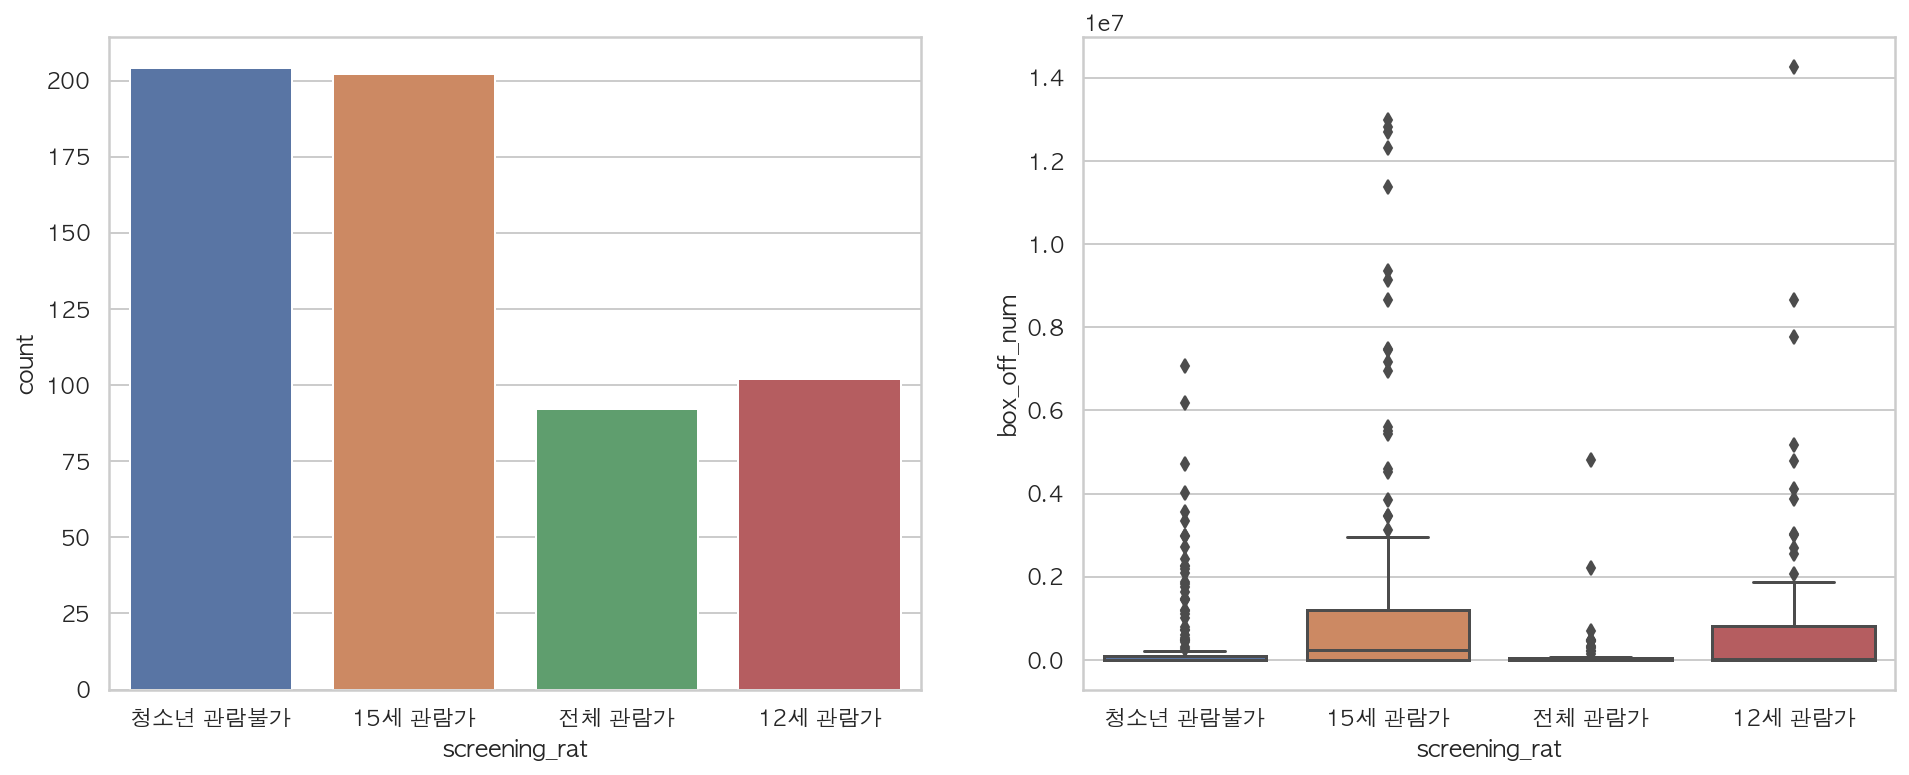

In [28]:
# 차트를 여러개 그리기 위한 설정을 합니다.
figure, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)

figure.set_size_inches(16, 6) # 차트 크기를 가로 16인치, 세로 6인치로 고정합니다.

# countplot 으로 screening_rat 컬럼을 시각화 합니다.
sns.countplot(data = train, x = "screening_rat", ax = ax1)

# barplot 으로 screening_rat 종류별 관객수를 시각화 합니다.
sns.boxplot(data = train, x = "screening_rat", y = "box_off_num",ax = ax2)

청소년 관람불가 영화와 15세 관람가 영화가 비슷한 개봉 수를 나타내는데 반해 관객 수는 15세 관람가가 월등하게 높을 것을 확인 할 수 있습니다.

이는, 나이 제한에 따른 관객 수 감소에 따른 것이라고 추측할 수 있으며 비슷한 이유로 전체 관람가도 어린이 영화에는 나이에 따른 선호도가 분명히 존재할 것이므로 이것이 관객 수에 영향을 준 것이라고 추측할 수 있습니다.

### director 컬럼

In [29]:
# pivot_table 을 사용하여 director 컬럼 테이블을 만든 후
# table_director 라는 변수에 할당합니다.
table_director = pd.pivot_table(train,
                                index = "director", # index 는 director 컬럼으로 설정합니다.
                                values = "box_off_num", # values 는 box_off_num 컬럼으로 설정합니다.
                                aggfunc = ["sum", "count"]) # 누적 합계와 누적 갯수를 설정합니다.

# table_director 컬럼명을 sum, count 로 변경합니다.
table_director.columns = ["sum", "count"]

# table_director 을 sum 컬럼을 기준으로 높은 순으로 정렬한 후
# table_director 변수에 할당합니다.
table_director = table_director.sort_values(by = "sum", ascending = False)

table_director # table_director 를 출력합니다.

,sum,count
director,,
최동훈,25690504,2
이석훈,16425919,2
윤제균,14262766,1
추창민,13973002,2
이환경,13347092,2
우민호,11480550,4
강형철,11469079,2
양우석,11374879,1
류승완,9889560,2


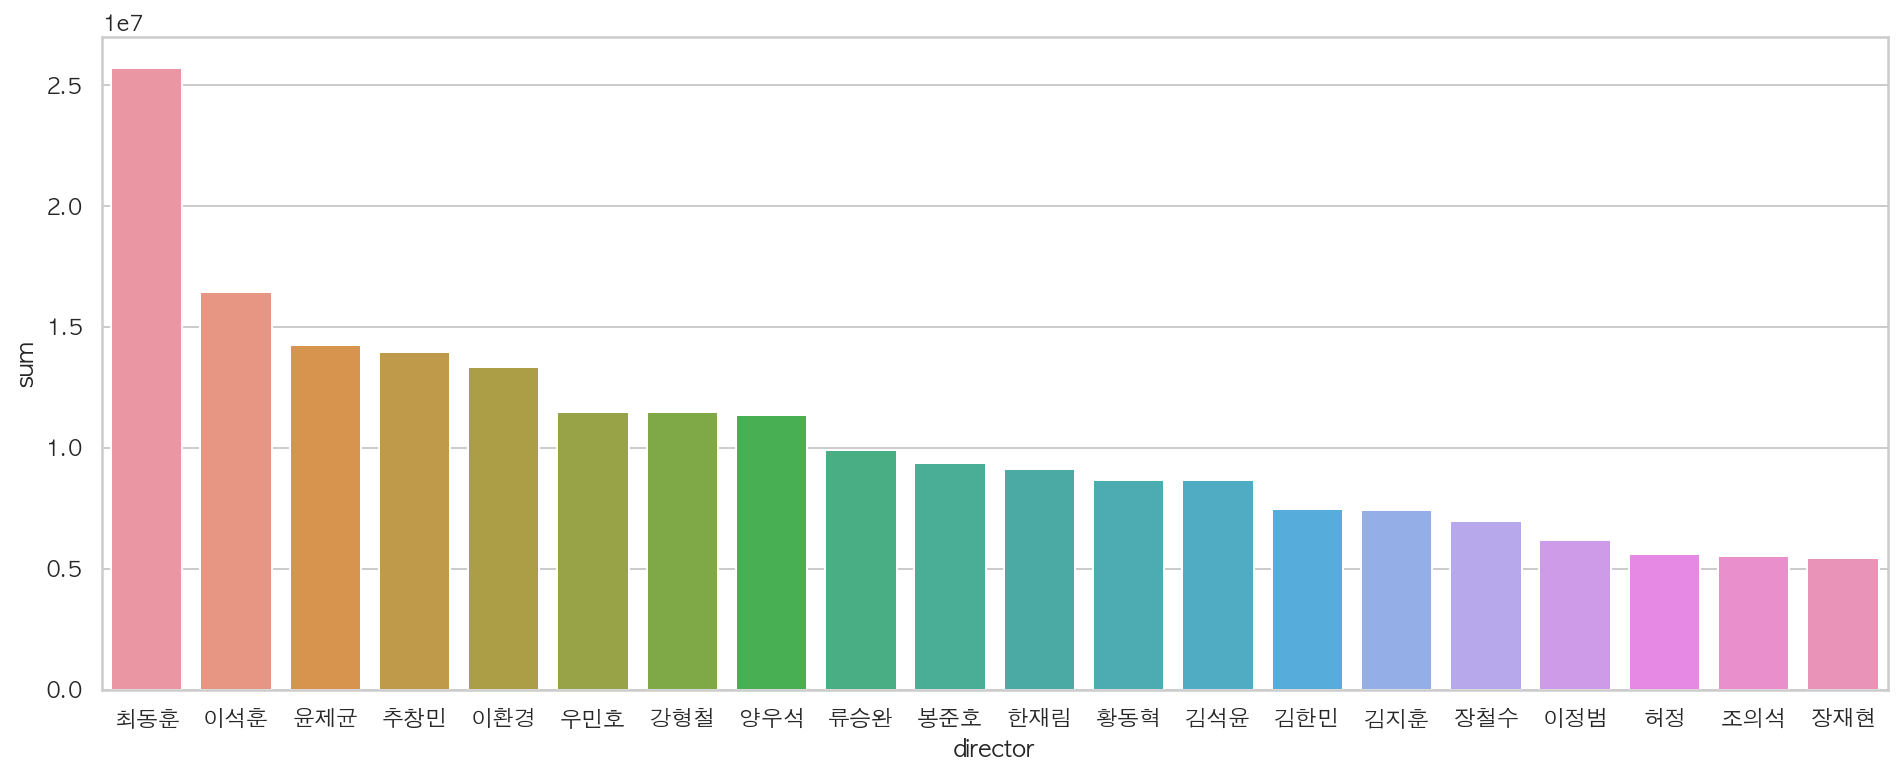

In [30]:
# table_director 상위 20명의 데이터를 table_director_top20 라는 변수에 할당합니다.
table_director_top20 = table_director.head(20)

plt.figure(figsize = (16, 6)) # 차트 크기를 가로 16인치, 세로 6인치로 설정합니다.

# seaborn 의 barplot 을 사용하여 table_director_top20 을 시각화 합니다.
sns.barplot(data = table_director_top20,
            x = table_director_top20.index, # x 축은 table_director_top20.index 로 설정합니다.
            y = "sum", # y 축은 sum 컬럼으로 설정합니다.
            order = table_director_top20.index) # x 축 순서는 table_director_top20의 index 순서로 설정합니다.

영화 감독의 네임 벨류에 따른 관객수의 차이가 어느정도 있음을 추측 할 수 있습니다.

### dir_prev_bfnum 컬럼

- dir_prev_bfnum_clean 컬럼을 사용

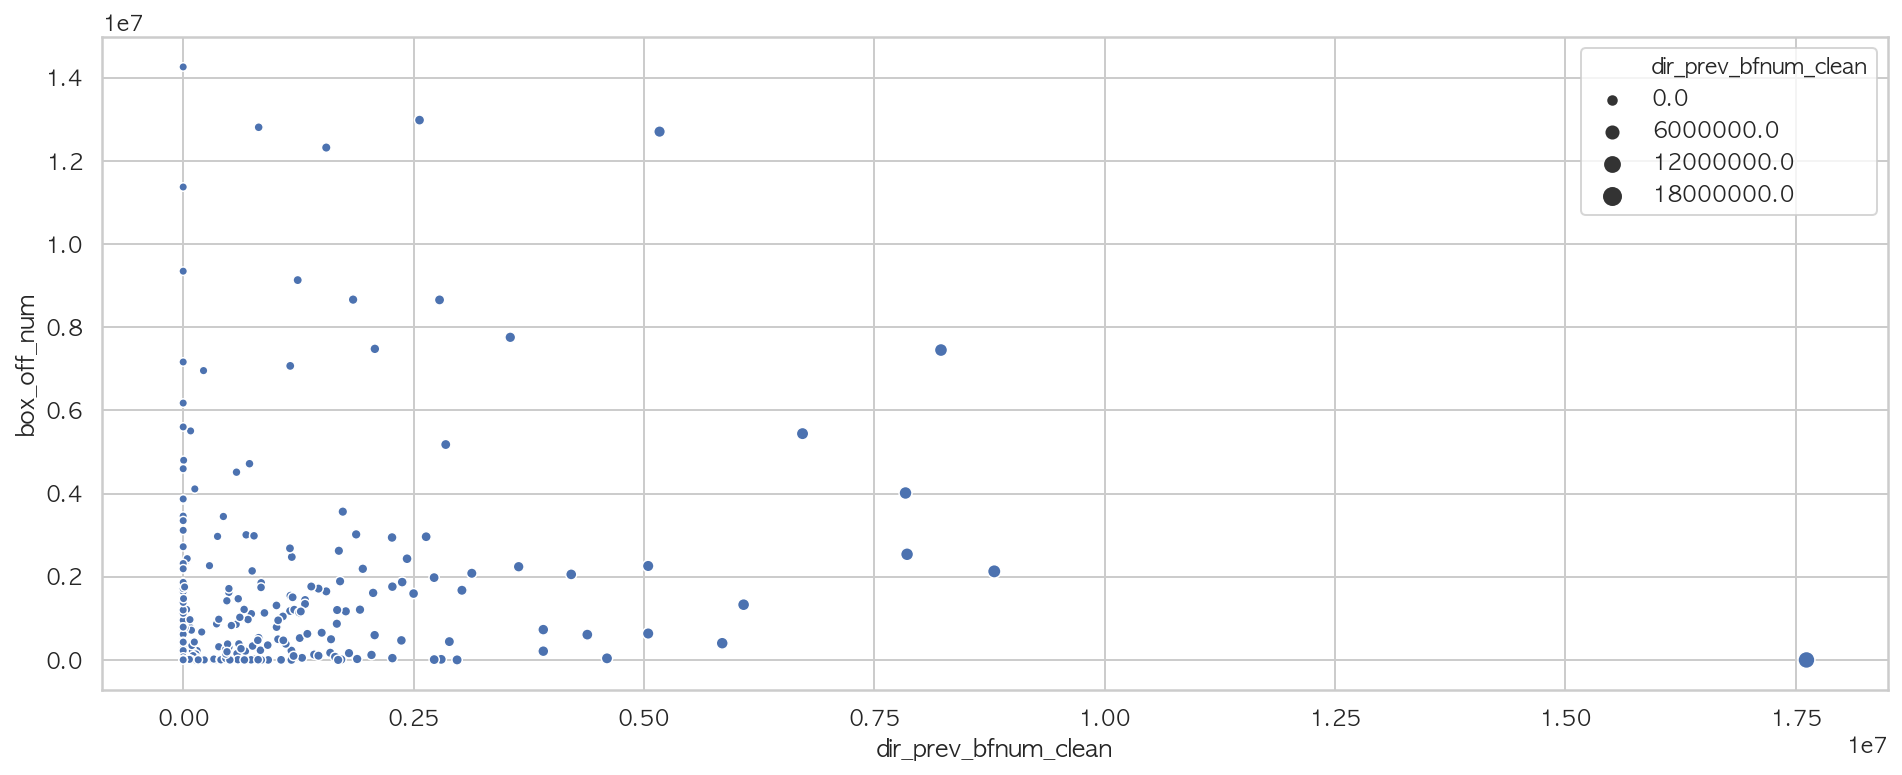

In [31]:
plt.figure(figsize = (16, 6)) # 차트 크기를 가로 16인치, 세로 6인치로 설정합니다.

# scatterplot 으로 dir_prev_bfnum_clean 종류별 관객수를 시각화 합니다.
sns.scatterplot(data = train, x = "dir_prev_bfnum_clean", y = "box_off_num", size = "dir_prev_bfnum_clean")

이전 영화에서의 관객 수는 250만명 이하에 대부분 분포하고 있으며, 신입 감독으로 추측되는 이전 영화 관객 수가 0명인 일부 감독도 높은 관객 수를 기록한 것을 확인 할 수 있습니다.

In [32]:
# dir_prev_bfnum_clean 컬럼의 최대값을 확인합니다.
train["dir_prev_bfnum_clean"].max()

17615314.0

In [33]:
# dir_prev_bfnum_clean 컬럼에서 최대값을 가지고 있는 데이터를 확인합니다.
train[train["dir_prev_bfnum_clean"] == 17615314]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday
338,타부 : 금지된 사랑,고구마공작소,멜로/로맨스,2015-09-03,78,청소년 관람불가,고구마,17615314.0,1,27,3,8,17615314.0,2015,9,3,Thursday


17,615,314 명의 관객 수를 기록한 영화를 확인 결과 실제 영화와 데이터의 내용이 다름을 알 수 있습니다. (실제 영화 - [명량](https://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query=%EB%AA%85%EB%9F%89&oquery=1700%EB%A7%8C+%EA%B4%80%EA%B0%9D&tqi=Um%2FbVsp0Jy0ssdrbOeCssssssz4-231773))

따라서, 위 영화의 이전 관객 수를 0 으로 변경 처리하도록 하겠습니다. 

In [34]:
# dir_prev_bfnum_clean 컬럼 값이 17615314 인 데이터를 0 으로 처리합니다.
train.loc[train["dir_prev_bfnum_clean"] == 17615314, "dir_prev_bfnum_clean"] = 0

# dir_prev_bfnum_clean 컬럼의 최대값을 확인합니다.
train["dir_prev_bfnum_clean"].max()

8801639.0

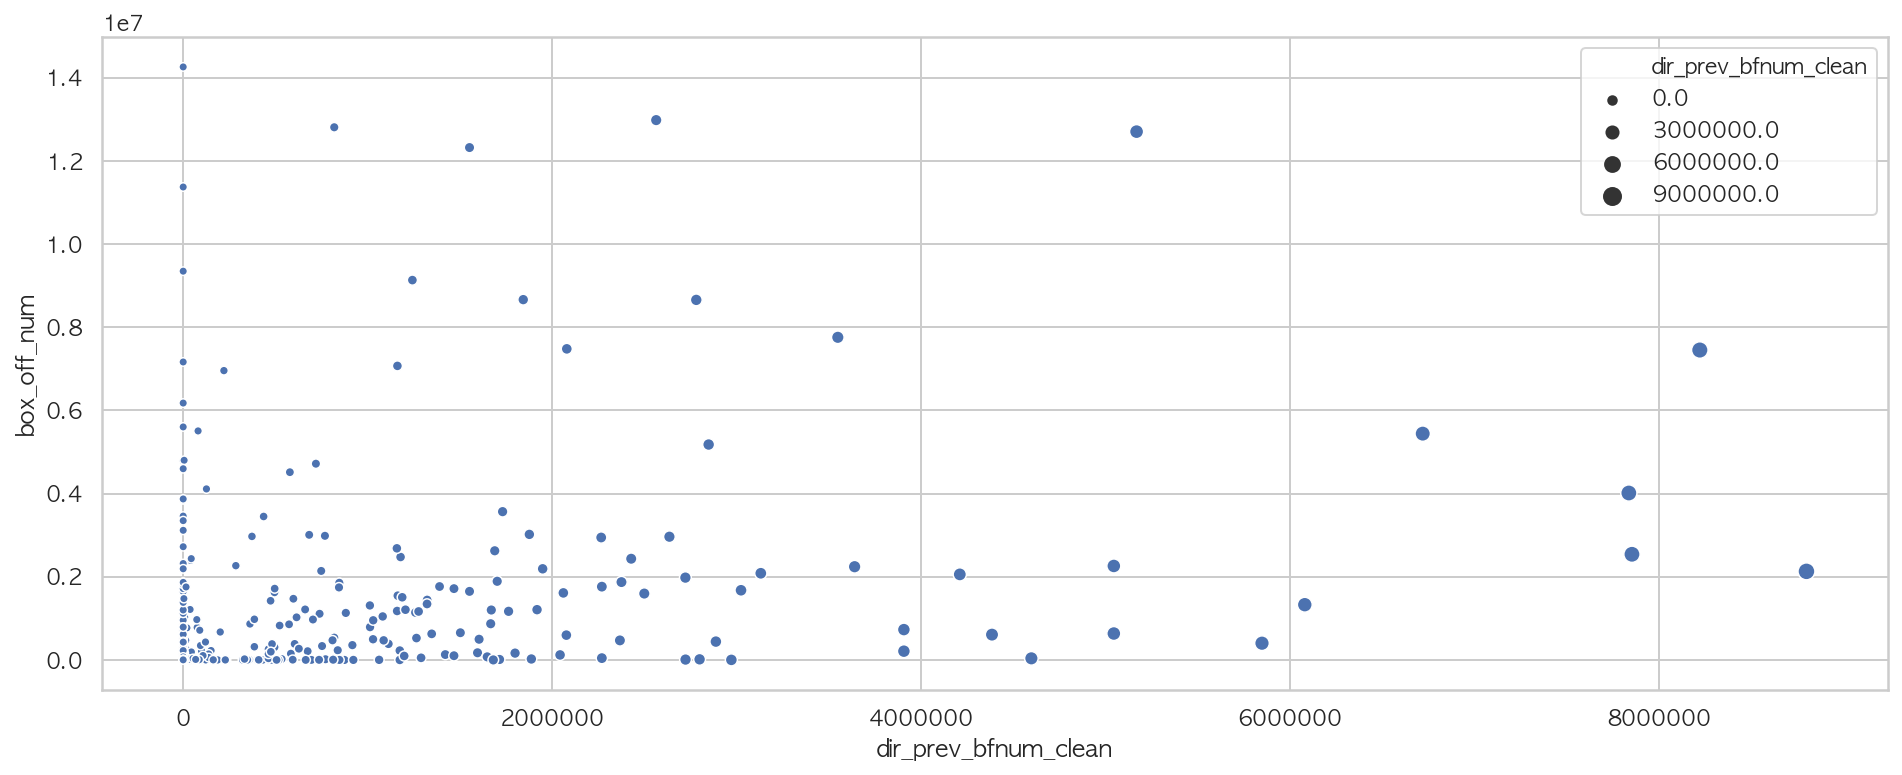

In [35]:
# dir_prev_bfnum_clean 종류별 관객수를 재 시각화 합니다.

plt.figure(figsize = (16, 6)) 

sns.scatterplot(data = train, x = "dir_prev_bfnum_clean", y = "box_off_num", size = "dir_prev_bfnum_clean")

### dir_prev_num 컬럼

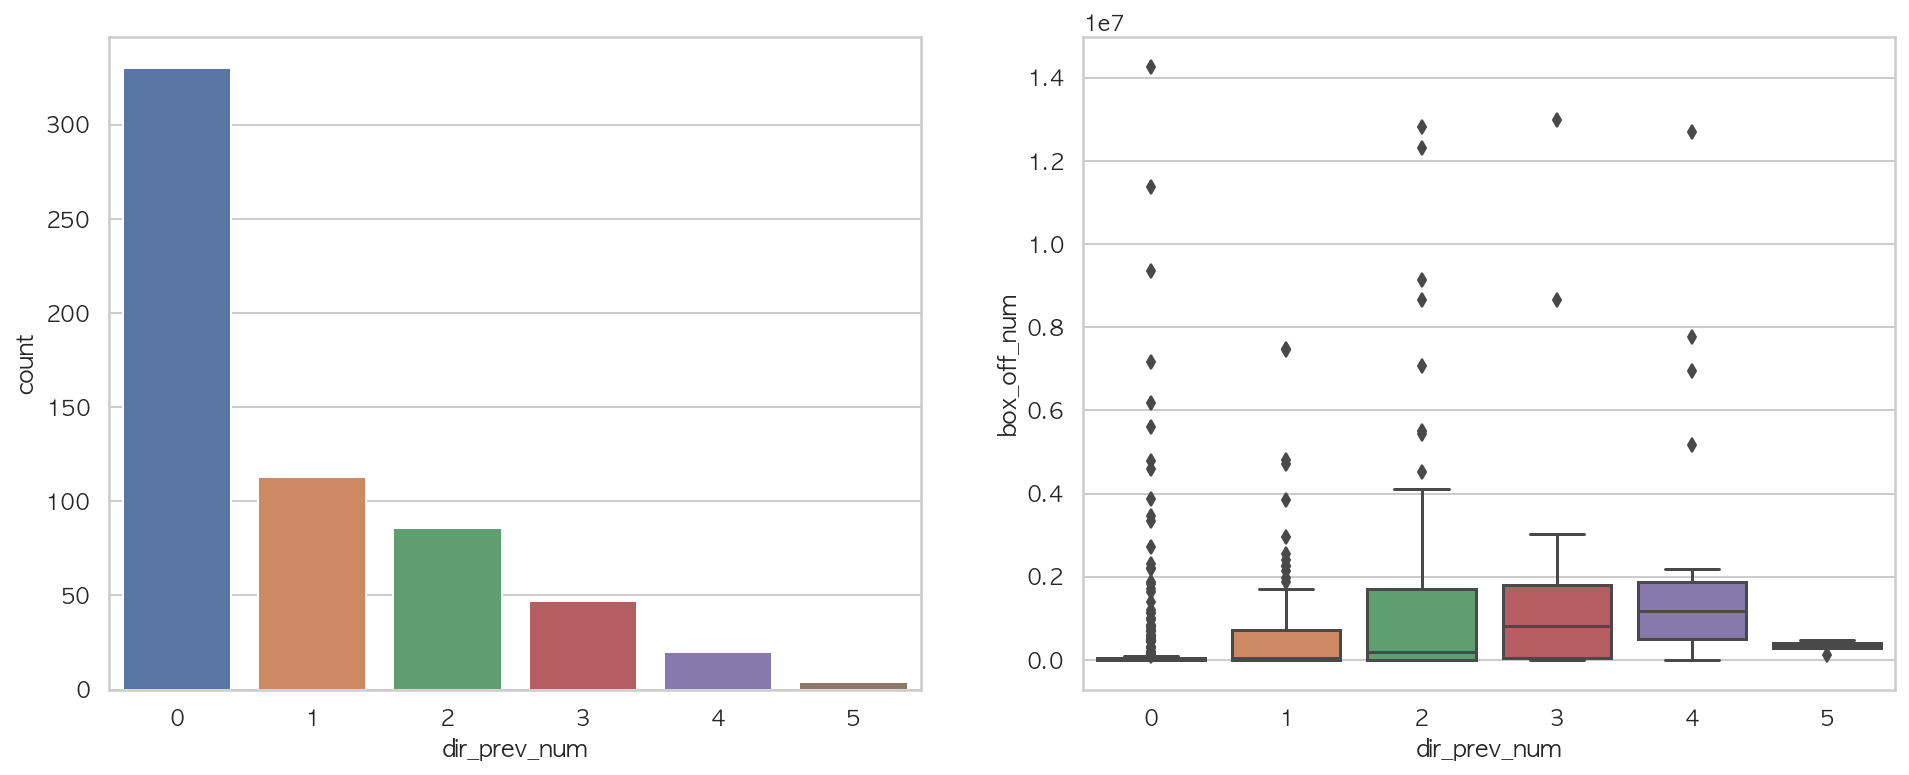

In [36]:
# 차트를 여러개 그리기 위한 설정을 합니다.
figure, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)

figure.set_size_inches(16, 6) # 차트 크기를 가로 16인치, 세로 6인치로 설정 합니다.

# countplot 으로 dir_prev_num 컬럼을 시각화 합니다.
sns.countplot(data = train, x = "dir_prev_num", ax = ax1)

# boxplot 으로 dir_prev_num 컬럼의 종류별 관객수를 시각화 합니다.
sns.boxplot(data = train, x = "dir_prev_num", y = "box_off_num",ax = ax2)

대부분 이전 작품이 없는 감독이라는 것을 확인 할 수 있으며 작품 수에 따라 관객 수에 영향이 있다는 것을 추측 할 수 있습니다.

다만, 이전 작품이 5개인 감독이라도 관객 수가 상당히 적은 것으로 볼때, 이전 작품 수가 절대적인 영향이 있다고 보기는 어렵다고 생각 할 수 있습니다.

### num_staff 컬럼

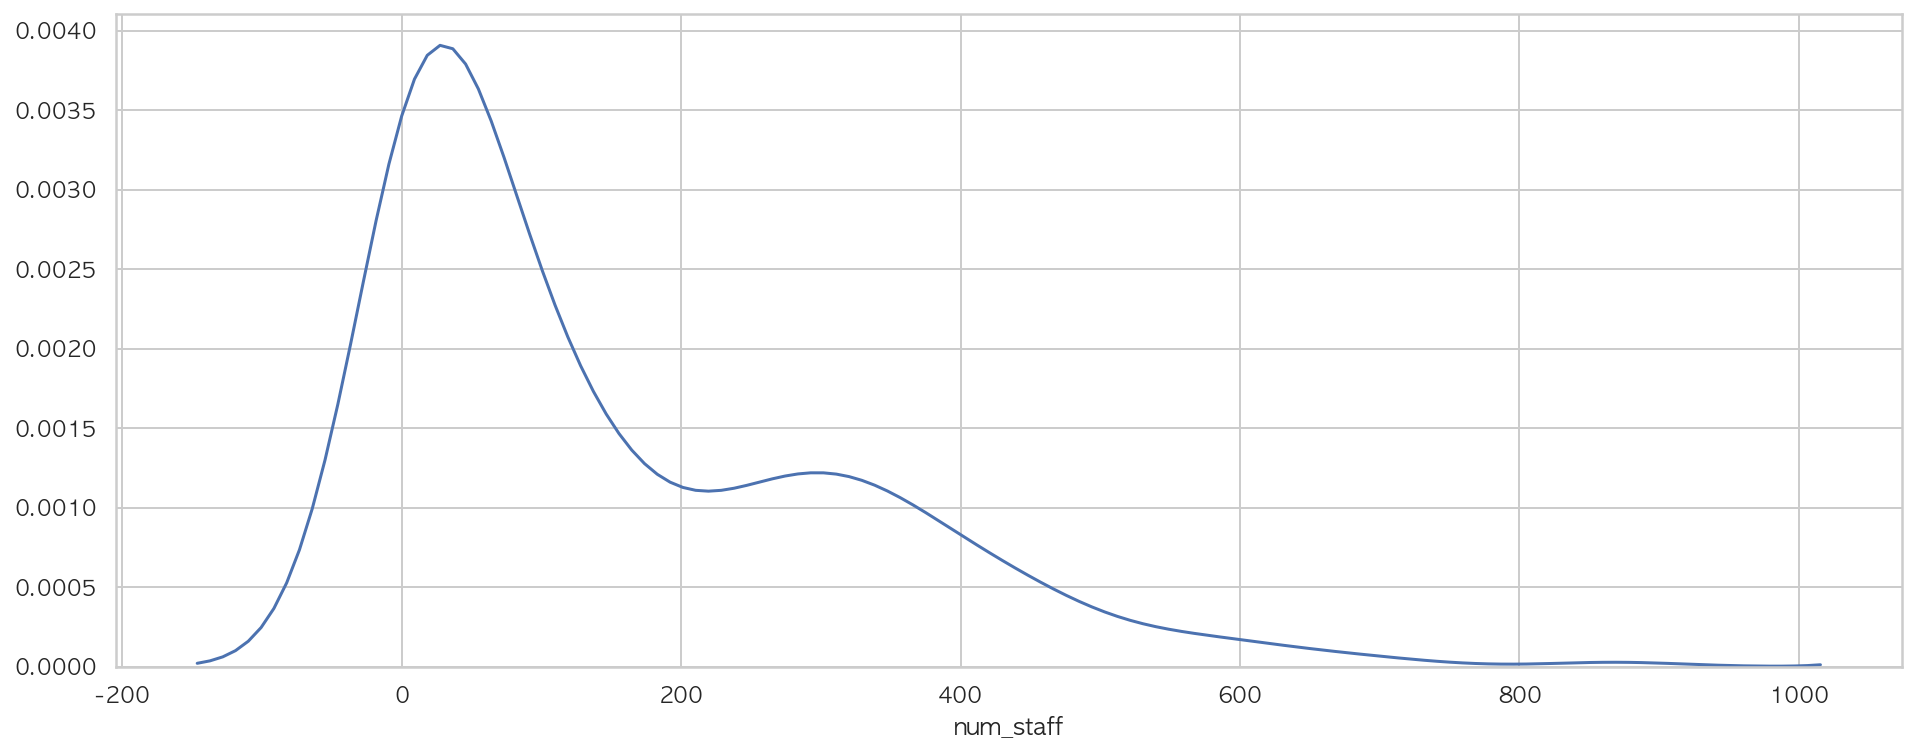

In [37]:
plt.figure(figsize = (16, 6)) # 차트 크기를 가로 16인치, 세로 6인치로 설정합니다.

# distplot 으로 num_staff 컬럼을 시각화 합니다.
# hist = False 를 설정하여 히스토그램은 그리지 않습니다.
sns.distplot(train["num_staff"], hist = False)

스탭 인원이 200명 이하인 작품이 상당수를 차지 한다는 것을 알 수 있습니다.

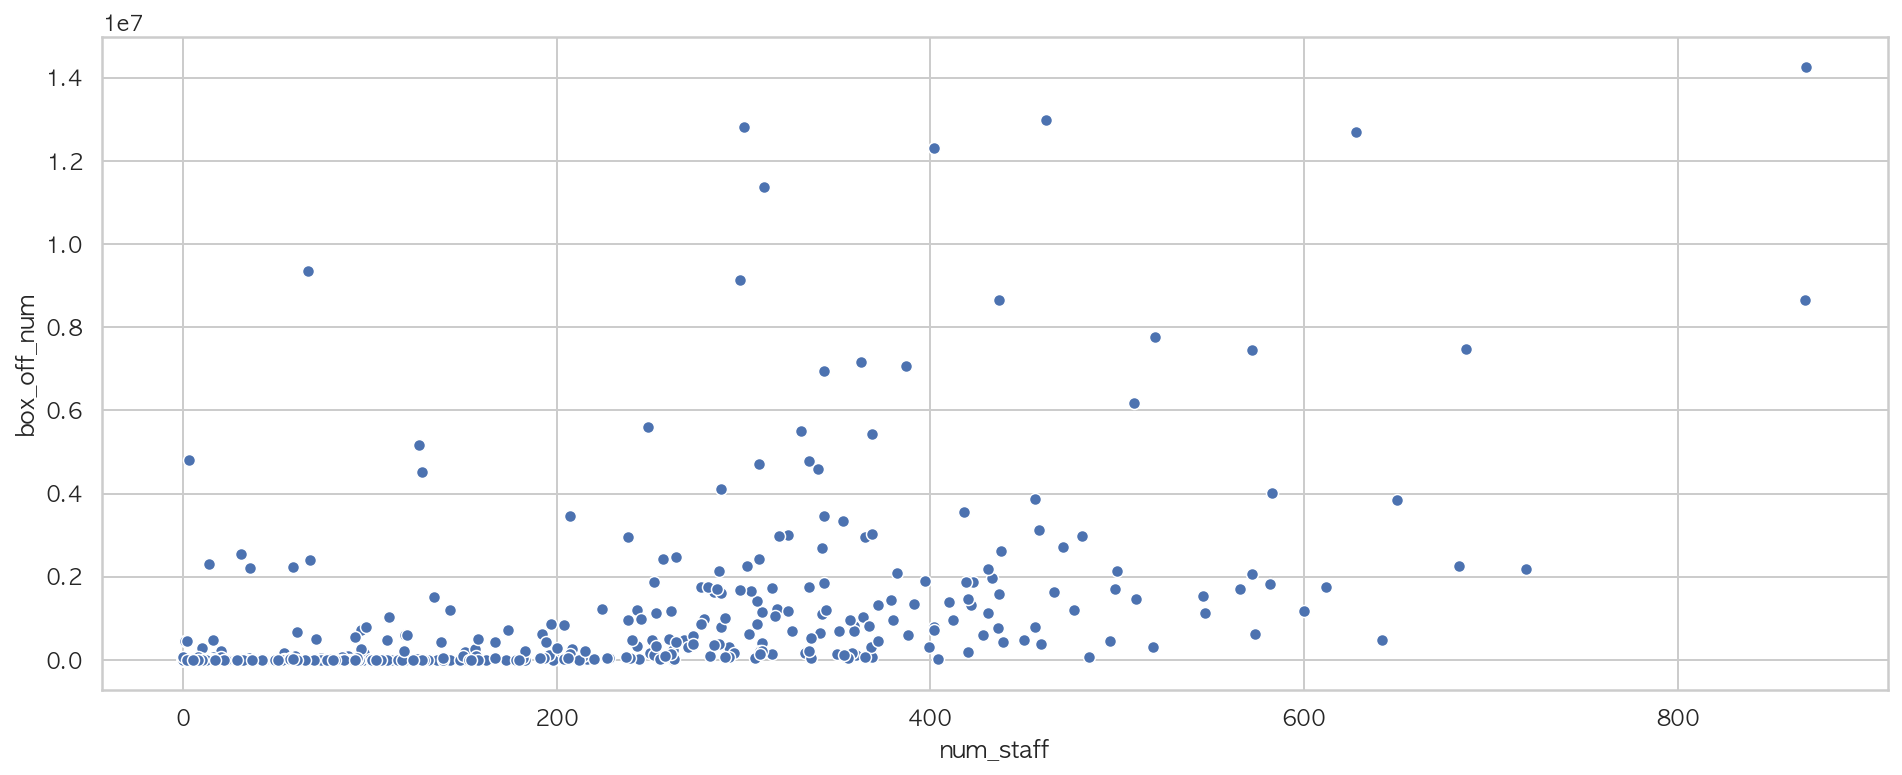

In [38]:
plt.figure(figsize = (16, 6)) # 차트 크기를 가로 16인치, 세로 6인치로 설정합니다.

# scatterplot 으로 num_staff 컬럼 종류별 관객 수를 시각화 합니다.
sns.scatterplot(data = train, x = "num_staff", y = "box_off_num")

스탭 인원이 적어도 관객 수가 많은 영화가 있는 반면, 많은 스탭 인원으로도 관객 수가 적은 영화가 있다는 것을 확인 할 수 있습니다.

스탭 인원이 많다는 것은 그만큼 스케일이 큰 영화라고 볼 수 있으며, 영화 스케일과 관객 수는 상관 관계가 그다지 없다는 것을 추측 할 수 있습니다.

### num_actor 컬럼

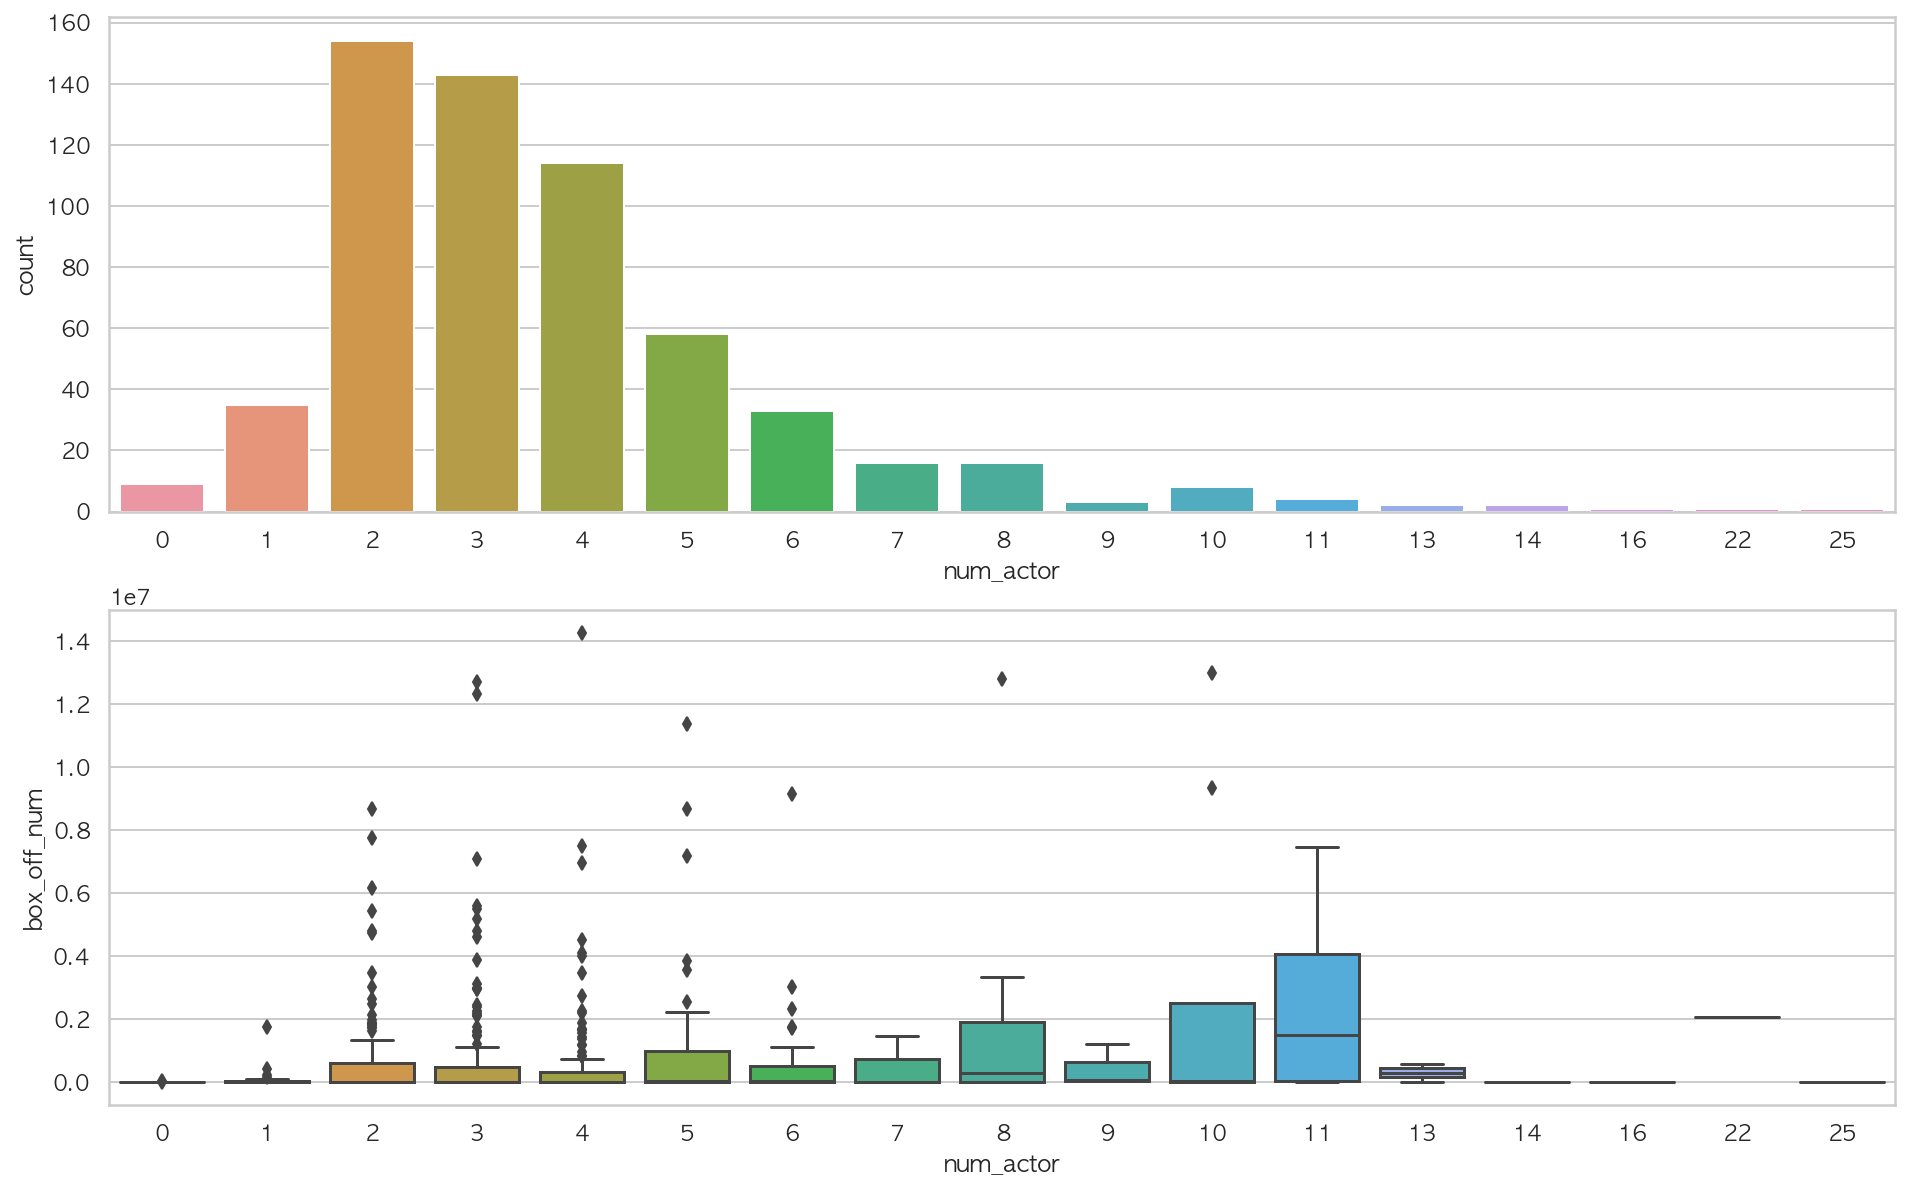

In [39]:
# 차트를 여러개 그리기 위한 설정을 합니다.
figure, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1)

figure.set_size_inches(16, 10) # 차트 크기를 가로 16인치, 세로 6인치로 설정 합니다.

# countplot 으로 num_actor 컬럼을 시각화 합니다.
sns.countplot(data = train, x = "num_actor", ax = ax1)

# boxplot 으로 num_actor 컬럼의 종류별 관객수를 시각화 합니다.
sns.boxplot(data = train, x = "num_actor", y = "box_off_num",ax = ax2)

주연 배우가 2 ~ 4명인 영화가 대부분을 차지하고 있지만, 관객 수는 주연 배우 숫자와 상관 없이 분포하고 있는 것을 볼 때 주연 배우 숫자는 관객 수에 큰 영향을 주지 않는 다는 것을 추측 할 수 있습니다.

---

In [40]:
list_1 = train["distributor"].unique()
list_2 = test["distributor"].unique()

In [41]:
train["distributor"].isin(list_2)

0      True
1      True
2      True
3      True
4      True
       ... 
595    True
596    True
597    True
598    True
599    True
Name: distributor, Length: 600, dtype: bool

## Feature engineering

### distributor 컬럼 one hot encoding

In [42]:
# train 데이터와 test 데이터에 동일하게 존재하는 배급사 외에는
# other 로 처리 합니다.

distributor = train[train["distributor"].isin(test["distributor"])]

distributor_list = distributor["distributor"].unique()

def find_distributor(row):
    if row in distributor_list:
        return row
    
    else:
        return "other"

In [43]:
train["distributor_clean"] = train["distributor"].apply(find_distributor)

print(train.shape)
train[["distributor", "distributor_clean"]].head()

(600, 18)


,distributor,distributor_clean
0,롯데엔터테인먼트,롯데엔터테인먼트
1,(주)쇼박스,(주)쇼박스
2,(주)쇼박스,(주)쇼박스
3,(주)NEW,(주)NEW
4,쇼박스(주)미디어플렉스,쇼박스(주)미디어플렉스


In [44]:
# test 데이터도 동일하게 처리합니다.

distributor = test[test["distributor"].isin(train["distributor"])]

distributor_list = distributor["distributor"].unique()

def find_distributor(row):
    if row in distributor_list:
        return row
    
    else:
        return "other"

In [45]:
test["distributor_clean"] = test["distributor"].apply(find_distributor)

print(test.shape)
test[["distributor", "distributor_clean"]].head()

(243, 17)


,distributor,distributor_clean
0,시네마서비스,시네마서비스
1,(주)쇼박스,(주)쇼박스
2,CJ 엔터테인먼트,CJ 엔터테인먼트
3,(주)쇼박스,(주)쇼박스
4,CJ 엔터테인먼트,CJ 엔터테인먼트


In [46]:
# get_dummies 함수 사용하여 distributor_clean 컬럼을 One Hot Encoding 후
# train_distributor 라는 변수에 할당합니다.
# 접두사(prefix)에는 distributor 를 설정합니다.
train_distributor = pd.get_dummies(train["distributor_clean"], prefix = "distributor")

# train 와 train_distributor 를 하나로 합친 후 train 변수에 다시 할당합니다.
train = pd.concat([train, train_distributor], axis = 1)

print(train.shape) # train 의 row, column 갯수를 출력합니다.
train.head() # train 의 상위 5개 자료를 출력합니다.

(600, 77)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday,distributor_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,0.0,2012,11,22,Thursday,롯데엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,1161602.0,2015,11,19,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,220775.0,2013,6,5,Wednesday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,23894.0,2012,7,12,Thursday,(주)NEW,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,1.0,2010,11,4,Thursday,쇼박스(주)미디어플렉스,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
# test 데이터도 train 과 동일하게 처리합니다.

test_distributor = pd.get_dummies(test["distributor_clean"], prefix = "distributor")
test = pd.concat([test, test_distributor], axis = 1)

print(test.shape) # test 의 row, column 갯수를 출력합니다.
test.head() # test 의 상위 5개 자료를 출력합니다.

(243, 76)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday,distributor_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,300529.0,2010,1,7,Thursday,시네마서비스,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,342700.0,2010,1,14,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,4206611.0,2010,1,28,Thursday,CJ 엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2,691342.0,2010,2,4,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1,31738.0,2010,2,18,Thursday,CJ 엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### genre 컬럼 one hot encoding

In [48]:
# train["genre"] = train["genre"].str.replace("멜로/로맨스","멜로_로맨스")

In [49]:
# get_dummies 함수 사용하여 genre 컬럼을 One Hot Encoding 후
# train_genre 라는 변수에 할당합니다.
# 접두사(prefix)에는 genre 를 설정합니다.
train_genre = pd.get_dummies(train["genre"], prefix = "genre")

# train 와 train_genre 를 하나로 합친 후 train 변수에 다시 할당합니다.
train = pd.concat([train, train_genre], axis = 1)

print(train.shape) # train 의 row, column 갯수를 출력합니다.
train.head() # train 의 상위 5개 자료를 출력합니다.

(600, 89)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday,distributor_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,0.0,2012,11,22,Thursday,롯데엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,1161602.0,2015,11,19,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,220775.0,2013,6,5,Wednesday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,23894.0,2012,7,12,Thursday,(주)NEW,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,1.0,2010,11,4,Thursday,쇼박스(주)미디어플렉스,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [50]:
# test 도 train 과 동일하게 처리합니다.

test_genre = pd.get_dummies(test["genre"], prefix = "genre")
test = pd.concat([test, test_genre], axis = 1)

print(test.shape) # test 의 row, column 갯수를 출력합니다.
test.head() # test 의 상위 5개 자료를 출력합니다.

(243, 88)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday,distributor_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,300529.0,2010,1,7,Thursday,시네마서비스,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,342700.0,2010,1,14,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,4206611.0,2010,1,28,Thursday,CJ 엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2,691342.0,2010,2,4,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1,31738.0,2010,2,18,Thursday,CJ 엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### screening_rat 컬럼 one hot encoding

In [51]:
# get_dummies 함수 사용하여 screening_rat 컬럼을 One Hot Encoding 후
# train_screening_rat 라는 변수에 할당합니다.
# 접두사(prefix)에는 screening_rat 를 설정합니다.
train_screening_rat = pd.get_dummies(train["screening_rat"], prefix = "screening_rat")

# train 와 train_screening_rat 를 하나로 합친 후 train 변수에 다시 할당합니다.
train = pd.concat([train, train_screening_rat], axis = 1)

print(train.shape) # train 의 row, column 갯수를 출력합니다.
train.head() # train 의 상위 5개 자료를 출력합니다.

(600, 93)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday,distributor_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,0.0,2012,11,22,Thursday,롯데엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,1161602.0,2015,11,19,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,220775.0,2013,6,5,Wednesday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,23894.0,2012,7,12,Thursday,(주)NEW,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,1.0,2010,11,4,Thursday,쇼박스(주)미디어플렉스,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [52]:
# test 도 train 과 동일하게 처리 합니다.

test_screening_rat = pd.get_dummies(test["screening_rat"], prefix = "screening_rat")
test = pd.concat([test, test_screening_rat], axis = 1)

print(test.shape) # test 의 row, column 갯수를 출력합니다.
test.head() # test 의 상위 5개 자료를 출력합니다.

(243, 92)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday,distributor_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,300529.0,2010,1,7,Thursday,시네마서비스,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,342700.0,2010,1,14,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,4206611.0,2010,1,28,Thursday,CJ 엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2,691342.0,2010,2,4,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1,31738.0,2010,2,18,Thursday,CJ 엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### director 컬럼 one hot encoding

In [53]:
# train 데이터와 test 데이터에 동일하게 존재하는 감독 외에는
# other 로 처리 합니다.

train_director = train[train["director"].isin(test["director"])]

train_director_list = train_director["director"].unique()

def find_director(row):
    if row in train_director_list:
        return row
    
    else:
        return "other"

In [54]:
train["director_clean"] = train["director"].apply(find_director)

print(train.shape)

train[["director", "director_clean"]].head()

(600, 94)


,director,director_clean
0,조병옥,other
1,우민호,other
2,장철수,장철수
3,구자홍,other
4,신근호,other


In [55]:
# test 데이터도 train 데이터와 동일하게 처리 합니다.

test_director = test[test["director"].isin(train["director"])]

test_director_list = test_director["director"].unique()

def find_director(row):
    if row in test_director_list:
        return row
    
    else:
        return "other"

In [56]:
test["director_clean"] = test["director"].apply(find_director)

print(test.shape)

test[["director", "director_clean"]].head()

(243, 93)


,director,director_clean
0,김형준,other
1,이광재,other
2,강대규,other
3,장훈,장훈
4,권호영,other


In [57]:
# get_dummies 함수 사용하여 director 컬럼을 One Hot Encoding 후
# train_director 라는 변수에 할당합니다.
# 접두사(prefix)에는 director 를 설정합니다.
train_director = pd.get_dummies(train["director_clean"], prefix = "director")

# train 와 train_screening_rat 를 하나로 합친 후 train 변수에 다시 할당합니다.
train = pd.concat([train, train_director], axis = 1)

print(train.shape) # train 의 row, column 갯수를 출력합니다.
train.head() # train 의 상위 5개 자료를 출력합니다.

(600, 173)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday,distributor_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,director_clean,director_other,director_강우석,director_강효진,director_곽경택,director_구혜선,director_김경묵,director_김광식,director_김대승,director_김봉은,director_김상만,director_김상진,director_김상철,director_김성훈,director_김일종,director_김정욱,director_김정환,director_김정훈,director_김종철,director_김진만,director_김진무,director_김진영,director_김태균,director_김한민,director_김호준,director_김홍선,director_김회근,director_남기웅,director_류승완,director_민규동,director_민용근,director_민환기,director_박훈정,director_박흥식,director_방은진,director_방현준,director_백승화,director_변성현,director_봉만대,director_손석,director_신수원,director_신연식,director_신혜성,director_안상훈,director_오멸,director_윤여창,director_윤종빈,director_이광호,director_이상빈,director_이상우,director_이석훈,director_이성규,director_이송희일,director_이수성,director_이숭환,director_이재규,director_이재한,director_이전,director_이정범,director_이준익,director_임상수,director_임순례,director_임흥순,director_장건재,director_장진,director_장철수,director_장훈,director_전규환,director_전화성,director_정지영,director_조범구,director_조성규,director_조성희,director_진광교,director_최승호,director_한동호,director_한지원,director_홍상수,director_황동혁,director_황철민
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,0.0,2012,11,22,Thursday,롯데엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,other,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,1161602.0,2015,11,19,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,other,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,220775.0,2013,6,5,Wednesday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,장철수,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,나는 공무원이다,(주)NE

In [58]:
# test 데이터도 train 데이터와 동일하게 처리합니다.

test_director = pd.get_dummies(test["director_clean"], prefix = "director")
test = pd.concat([test, test_director], axis = 1)

print(test.shape) # train 의 row, column 갯수를 출력합니다.
test.head() # train 의 상위 5개 자료를 출력합니다.

(243, 172)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday,distributor_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,director_clean,director_other,director_강우석,director_강효진,director_곽경택,director_구혜선,director_김경묵,director_김광식,director_김대승,director_김봉은,director_김상만,director_김상진,director_김상철,director_김성훈,director_김일종,director_김정욱,director_김정환,director_김정훈,director_김종철,director_김진만,director_김진무,director_김진영,director_김태균,director_김한민,director_김호준,director_김홍선,director_김회근,director_남기웅,director_류승완,director_민규동,director_민용근,director_민환기,director_박훈정,director_박흥식,director_방은진,director_방현준,director_백승화,director_변성현,director_봉만대,director_손석,director_신수원,director_신연식,director_신혜성,director_안상훈,director_오멸,director_윤여창,director_윤종빈,director_이광호,director_이상빈,director_이상우,director_이석훈,director_이성규,director_이송희일,director_이수성,director_이숭환,director_이재규,director_이재한,director_이전,director_이정범,director_이준익,director_임상수,director_임순례,director_임흥순,director_장건재,director_장진,director_장철수,director_장훈,director_전규환,director_전화성,director_정지영,director_조범구,director_조성규,director_조성희,director_진광교,director_최승호,director_한동호,director_한지원,director_홍상수,director_황동혁,director_황철민
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,300529.0,2010,1,7,Thursday,시네마서비스,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,other,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,342700.0,2010,1,14,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,other,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,4206611.0,2010,1,28,Thursday,CJ 엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,other,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,의형제,(주)쇼박스,액션,2010-02

### release_time_weekday 컬럼 처리

In [59]:
def clean_weekday(row):
    if row == "Wednesday" or row == "Thursday":
        return True
    
    else:
        return False

In [60]:
train["release_time_weekday_clean"] = train["release_time_weekday"].apply(clean_weekday)

print(train.shape)
train[["release_time_weekday", "release_time_weekday_clean"]].head()

(600, 174)


,release_time_weekday,release_time_weekday_clean
0,Thursday,True
1,Thursday,True
2,Wednesday,True
3,Thursday,True
4,Thursday,True


In [61]:
# test 도 train 과 동일하게 처리합니다.

test["release_time_weekday_clean"] = test["release_time_weekday"].apply(clean_weekday)

print(test.shape) # test 의 row, column 갯수를 출력합니다.
test[["release_time_weekday", "release_time_weekday_clean"]].head() # test 의 상위 5개 자료를 출력합니다.

(243, 173)


,release_time_weekday,release_time_weekday_clean
0,Thursday,True
1,Thursday,True
2,Thursday,True
3,Thursday,True
4,Thursday,True


In [62]:
train.columns

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff',
       ...
       'director_조성규', 'director_조성희', 'director_진광교', 'director_최승호',
       'director_한동호', 'director_한지원', 'director_홍상수', 'director_황동혁',
       'director_황철민', 'release_time_weekday_clean'],
      dtype='object', length=174)

In [106]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday,distributor_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,director_clean,director_other,director_강우석,director_강효진,director_곽경택,director_구혜선,director_김경묵,director_김광식,director_김대승,director_김봉은,director_김상만,director_김상진,director_김상철,director_김성훈,director_김일종,director_김정욱,director_김정환,director_김정훈,director_김종철,director_김진만,director_김진무,director_김진영,director_김태균,director_김한민,director_김호준,director_김홍선,director_김회근,director_남기웅,director_류승완,director_민규동,director_민용근,director_민환기,director_박훈정,director_박흥식,director_방은진,director_방현준,director_백승화,director_변성현,director_봉만대,director_손석,director_신수원,director_신연식,director_신혜성,director_안상훈,director_오멸,director_윤여창,director_윤종빈,director_이광호,director_이상빈,director_이상우,director_이석훈,director_이성규,director_이송희일,director_이수성,director_이숭환,director_이재규,director_이재한,director_이전,director_이정범,director_이준익,director_임상수,director_임순례,director_임흥순,director_장건재,director_장진,director_장철수,director_장훈,director_전규환,director_전화성,director_정지영,director_조범구,director_조성규,director_조성희,director_진광교,director_최승호,director_한동호,director_한지원,director_홍상수,director_황동혁,director_황철민,release_time_weekday_clean
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,0.0,2012,11,22,Thursday,롯데엔터테인먼트,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,other,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,1161602.0,2015,11,19,Thursday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,other,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,220775.0,2013,6,5,Wednesday,(주)쇼박스,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,장철수,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

In [124]:
# 사용할 feature 를 feature_name 이라는 변수에 할당합니다.

feature_name = ["time", "dir_prev_num", "num_staff", "num_actor", "dir_prev_bfnum_clean"]

feature_name = feature_name + ["release_time_year", "release_time_month", "release_time_day", "release_time_weekday_clean"]

feature_name = feature_name + list(train_distributor.columns) 
feature_name = feature_name + list(train_genre.columns)
feature_name = feature_name + list(train_screening_rat.columns)
feature_name = feature_name + list(train_director.columns)

feature_name # feature 를 출력합니다.

['time',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'dir_prev_bfnum_clean',
 'release_time_year',
 'release_time_month',
 'release_time_day',
 'release_time_weekday_clean',
 'distributor_(주) 액티버스엔터테인먼트',
 'distributor_(주) 영화사조제',
 'distributor_(주) 영화제작전원사',
 'distributor_(주) 케이알씨지',
 'distributor_(주)NEW',
 'distributor_(주)노버스엔터테인먼트',
 'distributor_(주)두타연',
 'distributor_(주)마운틴픽쳐스',
 'distributor_(주)마인스 엔터테인먼트',
 'distributor_(주)미디어데이',
 'distributor_(주)쇼박스',
 'distributor_(주)스톰픽쳐스코리아',
 'distributor_(주)에이원 엔터테인먼트',
 'distributor_(주)엣나인필름',
 'distributor_(주)예지림 엔터테인먼트',
 'distributor_(주)키노아이',
 'distributor_(주)팝엔터테인먼트',
 'distributor_BoXoo 엔터테인먼트',
 'distributor_CGV아트하우스',
 'distributor_CJ E&M Pictures',
 'distributor_CJ 엔터테인먼트',
 'distributor_KT&G 상상마당',
 'distributor_NEW',
 'distributor_SBS콘텐츠허브',
 'distributor_other',
 'distributor_골든타이드픽처스',
 'distributor_나이너스엔터테인먼트(주)',
 'distributor_노바엔터테인먼트',
 'distributor_드림로드',
 'distributor_롯데엔터테인먼트',
 'distributor_리틀빅픽처스',
 'distributor_메가

In [125]:
label_name = "box_off_num"

label_name

'box_off_num'

In [126]:
# feature_name 을 사용하여 train 의 feature 를 가져와 X_train 이라는 변수에 할당합니다.
X_train = train[feature_name]

print(X_train.shape) # X_train 의 row, column 갯수를 출력합니다.
X_train.head() # X_train 의 상위 5개 자료를 출력합니다. 

(600, 163)


,time,dir_prev_num,num_staff,num_actor,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,director_other,director_강우석,director_강효진,director_곽경택,director_구혜선,director_김경묵,director_김광식,director_김대승,director_김봉은,director_김상만,director_김상진,director_김상철,director_김성훈,director_김일종,director_김정욱,director_김정환,director_김정훈,director_김종철,director_김진만,director_김진무,director_김진영,director_김태균,director_김한민,director_김호준,director_김홍선,director_김회근,director_남기웅,director_류승완,director_민규동,director_민용근,director_민환기,director_박훈정,director_박흥식,director_방은진,director_방현준,director_백승화,director_변성현,director_봉만대,director_손석,director_신수원,director_신연식,director_신혜성,director_안상훈,director_오멸,director_윤여창,director_윤종빈,director_이광호,director_이상빈,director_이상우,director_이석훈,director_이성규,director_이송희일,director_이수성,director_이숭환,director_이재규,director_이재한,director_이전,director_이정범,director_이준익,director_임상수,director_임순례,director_임흥순,director_장건재,director_장진,director_장철수,director_장훈,director_전규환,director_전화성,director_정지영,director_조범구,director_조성규,director_조성희,director_진광교,director_최승호,director_한동호,director_한지원,director_홍상수,director_황동혁,director_황철민
0,96,0,91,2,0.0,2012,11,22,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,130,2,387,3,1161602.0,2015,11,19,True,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,123,4,343,4,220775.0,2013,6,5,True,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,101,2,20,6,23894.0,2012,7,12,True,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,108,1,251

In [127]:
# feature_name 을 사용하여 test 의 feature 를 가져와 X_test 이라는 변수에 할당합니다.
X_test = test[feature_name]

print(X_test.shape) # X_test 의 row, column 갯수를 출력합니다.
X_test.head() # X_test 의 상위 5개 자료를 출력합니다.

(243, 163)


,time,dir_prev_num,num_staff,num_actor,dir_prev_bfnum_clean,release_time_year,release_time_month,release_time_day,release_time_weekday_clean,distributor_(주) 액티버스엔터테인먼트,distributor_(주) 영화사조제,distributor_(주) 영화제작전원사,distributor_(주) 케이알씨지,distributor_(주)NEW,distributor_(주)노버스엔터테인먼트,distributor_(주)두타연,distributor_(주)마운틴픽쳐스,distributor_(주)마인스 엔터테인먼트,distributor_(주)미디어데이,distributor_(주)쇼박스,distributor_(주)스톰픽쳐스코리아,distributor_(주)에이원 엔터테인먼트,distributor_(주)엣나인필름,distributor_(주)예지림 엔터테인먼트,distributor_(주)키노아이,distributor_(주)팝엔터테인먼트,distributor_BoXoo 엔터테인먼트,distributor_CGV아트하우스,distributor_CJ E&M Pictures,distributor_CJ 엔터테인먼트,distributor_KT&G 상상마당,distributor_NEW,distributor_SBS콘텐츠허브,distributor_other,distributor_골든타이드픽처스,distributor_나이너스엔터테인먼트(주),distributor_노바엔터테인먼트,distributor_드림로드,distributor_롯데엔터테인먼트,distributor_리틀빅픽처스,distributor_메가박스(주)플러스엠,distributor_무비꼴라쥬,distributor_쇼박스(주)미디어플렉스,distributor_스토리셋,distributor_스폰지이엔티,distributor_시너지,distributor_시네마 달,distributor_시네마달,distributor_시네마서비스,distributor_싸이더스,distributor_씨너스엔터테인먼트(주),distributor_씨네굿필름,distributor_씨네그루(주)키다리이엔티,distributor_어뮤즈,distributor_에이원 엔터테인먼트,distributor_영화사 진진,distributor_오퍼스픽쳐스,distributor_웃기씨네,distributor_위드시네마,distributor_이십세기폭스코리아(주),distributor_인디스토리,distributor_인디플러그,distributor_인벤트 디,distributor_크리에이티브컴즈(주),distributor_타임스토리그룹,distributor_트리필름,distributor_필라멘트 픽쳐스,distributor_하준사,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가,director_other,director_강우석,director_강효진,director_곽경택,director_구혜선,director_김경묵,director_김광식,director_김대승,director_김봉은,director_김상만,director_김상진,director_김상철,director_김성훈,director_김일종,director_김정욱,director_김정환,director_김정훈,director_김종철,director_김진만,director_김진무,director_김진영,director_김태균,director_김한민,director_김호준,director_김홍선,director_김회근,director_남기웅,director_류승완,director_민규동,director_민용근,director_민환기,director_박훈정,director_박흥식,director_방은진,director_방현준,director_백승화,director_변성현,director_봉만대,director_손석,director_신수원,director_신연식,director_신혜성,director_안상훈,director_오멸,director_윤여창,director_윤종빈,director_이광호,director_이상빈,director_이상우,director_이석훈,director_이성규,director_이송희일,director_이수성,director_이숭환,director_이재규,director_이재한,director_이전,director_이정범,director_이준익,director_임상수,director_임순례,director_임흥순,director_장건재,director_장진,director_장철수,director_장훈,director_전규환,director_전화성,director_정지영,director_조범구,director_조성규,director_조성희,director_진광교,director_최승호,director_한동호,director_한지원,director_홍상수,director_황동혁,director_황철민
0,125,2,304,3,300529.0,2010,1,7,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,113,4,275,3,342700.0,2010,1,14,True,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,115,3,419,7,4206611.0,2010,1,28,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,116,2,408,2,691342.0,2010,2,4,True,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,110

In [128]:
y_train = train[label_name]

print(y_train.shape)

# y_train 데이터의 상위 5개를 띄웁니다.
y_train.head()

(600,)


0      23398
1    7072501
2    6959083
3     217866
4     483387
Name: box_off_num, dtype: int64

---

## Evaluation

In [133]:
# LGBMRegressor 를 불러옵니다.
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# random_state 와 metric 만 설정 후 LGBMRegressor 를 model 이라는 변수에 할당합니다.
model = RandomForestRegressor(random_state = 37)

model # model 을 출력합니다.

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=37, verbose=0,
                      warm_start=False)

In [134]:
# cross_val_score 를 불러옵니다.
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(15, shuffle = True, random_state = 42)

# scoring 은 neg_mean_squared_error, cv 는 20으로 설정 후 
# cross validation 결과를 y_predict 라는 변수에 할당합니다.
y_predict = cross_val_score(model, X_train, y_train,
                            scoring="neg_mean_squared_error", cv = kf)

# RMSE 값을 score 라는 변수에 할당합니다.
score = np.sqrt(-y_predict)

In [135]:
def display_scores(scores): # score 의 점수, 평균, 표준편차를 설정하는 함수를 정의합니다.
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())

display_scores(score) # display_scores 함수에 score 를 대입합니다.

점수: [1127484.65893505 1825343.9328504  1245995.65863703  919837.26766728
 1619178.22602408 1323340.44624295  918973.91995594 1898638.83348333
 2163615.24049273 1923450.41081963  957767.26044929 2637561.72313278
 1915373.00039249 1532006.90180065 1443740.96538851]
평균: 1563487.229751478
표준편차: 483850.0393593139


In [136]:
# 평균: 1563487.229751478

---

## Fit

In [137]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=37, verbose=0,
                      warm_start=False)

---

In [138]:
prediction = model.predict(X_test)

print(prediction.shape)
prediction

(243,)


array([3.2508194e+06, 1.3698290e+06, 7.3699240e+05, 1.4375627e+06,
       8.7943850e+05, 5.5282900e+04, 3.4866000e+03, 3.3214000e+03,
       1.5679500e+04, 4.9096840e+05, 2.0752080e+05, 1.7985724e+06,
       9.9008320e+05, 2.3092000e+03, 1.0803632e+06, 2.1147419e+06,
       8.7667300e+04, 2.5605582e+06, 1.4724520e+05, 9.2547600e+04,
       8.4040000e+02, 2.6339000e+03, 8.5651590e+05, 6.1604600e+04,
       2.3415410e+05, 1.2067975e+06, 3.3076000e+03, 7.7594080e+05,
       4.5476000e+03, 8.9757000e+03, 2.3489131e+06, 1.1275230e+05,
       2.3601000e+04, 4.7890663e+06, 8.6077000e+03, 2.3678210e+05,
       1.5088000e+03, 1.3185000e+04, 8.9432000e+03, 6.8460000e+02,
       8.9087000e+03, 2.7720000e+03, 4.2105000e+03, 5.1761140e+05,
       8.6830190e+05, 8.8605020e+05, 6.6340000e+02, 3.5049000e+04,
       8.6761240e+05, 9.0020000e+02, 1.2311130e+05, 3.5423740e+05,
       8.4605200e+04, 4.6547870e+05, 7.3969760e+05, 8.2737640e+05,
       1.5639600e+04, 5.0654760e+05, 1.9281103e+06, 6.3179708e

## Submit

In [139]:
submit = pd.read_csv("data/submission.csv")

# submit 의 value 컬럼에 prediction 값을 설정합니다.
submit["box_off_num"] = prediction.round()

# print(submit.shape) # submit 의 row, column 갯수를 출력합니다.
submit # submit 을 상위 5개 자료를 출력합니다.

,title,box_off_num
0,용서는 없다,3250819.0
1,아빠가 여자를 좋아해,1369829.0
2,하모니,736992.0
3,의형제,1437563.0
4,평행 이론,879438.0
5,회오리 바람,55283.0
6,경계도시 2,3487.0
7,이웃집 남자,3321.0
8,아마존의 눈물 극장판,15680.0
9,반가운 살인자,490968.0


In [140]:
submit.to_csv("submission.csv", index = False)